In [1031]:
from pathlib import Path
import numpy as np
import pandas as pd
import glob
import pickle
import matplotlib.pyplot as plt

# Load angle and 3D pose data

In [1032]:
data_path = Path("data/seqikpy_output")
with open(data_path / "leg_joint_angles.pkl", "rb") as f:
    angles_data = pickle.load(f)

with open(data_path / "pose3d_aligned.pkl", "rb") as f:
    pose_data = pickle.load(f)


In [1033]:
swing_stance_times = angles_data["swing_stance_time"]
data_len = len(pose_data["RF_leg"])
timestep = angles_data["meta"]["timestep"]
time = np.arange(0, data_len * timestep, timestep)

In [1034]:
init_pose_data = pd.read_csv(data_path / "../3D_pose_alfie/clean_3d_best_ventral_best_side.csv", index_col=0)
init_pose_data.head()

He_x      He_y        He_z  Th_x  Th_y   Th_z       Abd_x      Abd_y  \
0  69.292020  3.431979  158.301898   0.0   0.0  200.0 -119.182811  -8.775985   
1  70.382080  8.191071  160.496563   0.0   0.0  200.0 -115.578056 -12.920130   
2  71.720050  5.248166  159.257994   0.0   0.0  200.0 -120.824773 -11.473381   
3  73.947653  8.516508  153.795796   0.0   0.0  200.0 -116.706790 -11.340129   
4  72.287172  1.176794  152.641481   0.0   0.0  200.0 -113.394711  -8.666705   

        Abd_z   LF-ThC_x  ...  RF-Claw_y  RF-Claw_z        LA_x       LA_y  \
0   94.041692  49.160537  ... -63.247762  32.129260  130.396633  31.201803   
1   95.971455  48.294168  ... -58.678285  60.201446  132.824747  29.887862   
2   96.625071  44.555710  ... -37.167251  82.090790  134.342140  32.291463   
3  102.601823  49.905296  ... -34.644218  88.197503  136.149032  30.280832   
4  101.500755  46.685024  ... -36.748925  50.769037  135.008672  28.151512   

         LA_z        RA_x       RA_y        RA_z  frame_idx  video_id  
0  169.573072  133.514856  11.015287  170.305038         29         0  
1  167.769696  139.545005  11.037427  168.963729         30         0  
2  166.540473  138.013567   9.940637  167.349148         31         0  
3  163.140173  140.592925  10.860921  166.433141         32         0  
4  163.327386  139.692238   7.646796  163.283220         33         0  

[5 rows x 107 columns]

In [1035]:
joint_names = ["ThC", "CTr", "FTi", "TiTa"]

In [1036]:
formatted_angle_data = {}
dof_names = []
dof_name_conversion_dict = {
    "ThC":"Coxa",
    "CTr":"Femur",
    "FTi":"Tibia",
    "TiTa":"Tarsus1",
}
for side in ["R", "L"]:
    for segment in ["F", "M", "H"]:
        key = f"{side}{segment}_leg"
        formatted_angle_data[key] = []
        for angle_name, angle_values in angles_data.items():
            if f"{side}{segment}" in angle_name:
                formatted_angle_data[key].append(angle_values)
                if side == "R" and segment == "F":
                    _, leg, joint, dof = angle_name.split("_")
                    formatted_ang_name = f"{dof_name_conversion_dict[joint]}"
                    if not dof == "pitch":
                        formatted_ang_name += f"_{dof}"
                    dof_names.append(formatted_ang_name)
for key, values in formatted_angle_data.items():
    formatted_angle_data[key] = np.array(values).T
    print(formatted_angle_data[key].shape)
formatted_angle_data.keys(), dof_names

(94, 7)
(94, 7)
(94, 7)
(94, 7)
(94, 7)
(94, 7)


(dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg']),
 ['Coxa_yaw', 'Coxa', 'Coxa_roll', 'Femur', 'Femur_roll', 'Tibia', 'Tarsus1'])

# Plot leg tip trajectories in 2D

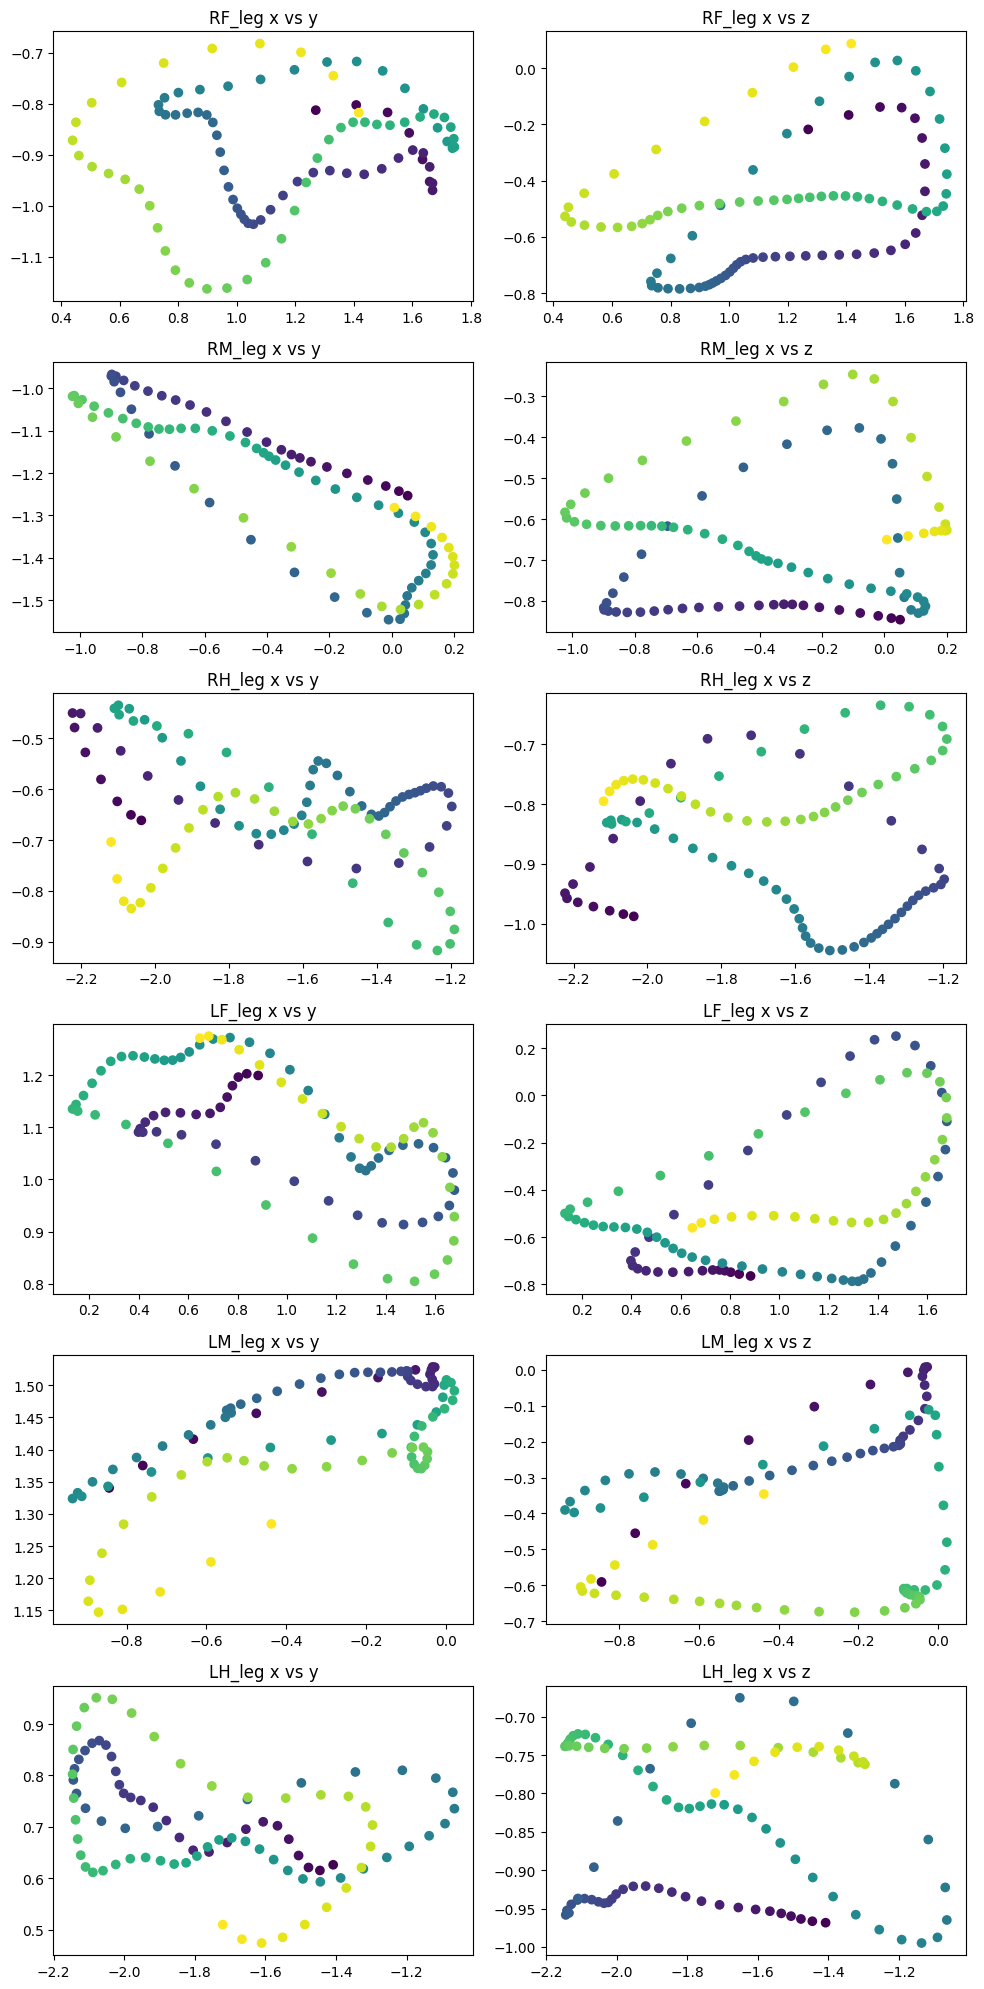

In [1037]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()
i = 0

# colormap evolving with time (ble to red)
cmap = np.array(plt.cm.viridis.colors )
colors = cmap[np.linspace(0, len(cmap)-1, len(pose_data["RF_leg"])).astype(int)]

joint_id = -1

for side in ["R", "L"]:
    for segment in ["F", "M", "H"]:
        axs[i].scatter(pose_data[f"{side}{segment}_leg"][:, joint_id, 0], pose_data[f"{side}{segment}_leg"][:, joint_id, 1], c=colors)
        axs[i].set_title(f"{side}{segment}_leg x vs y")
        i += 1
        axs[i].scatter(pose_data[f"{side}{segment}_leg"][:, joint_id, 0], pose_data[f"{side}{segment}_leg"][:, joint_id, 2], c=colors)
        axs[i].set_title(f"{side}{segment}_leg x vs z")
        i += 1
plt.tight_layout()


/Users/stimpfli/miniconda3/envs/flygym/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/stimpfli/miniconda3/envs/flygym/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


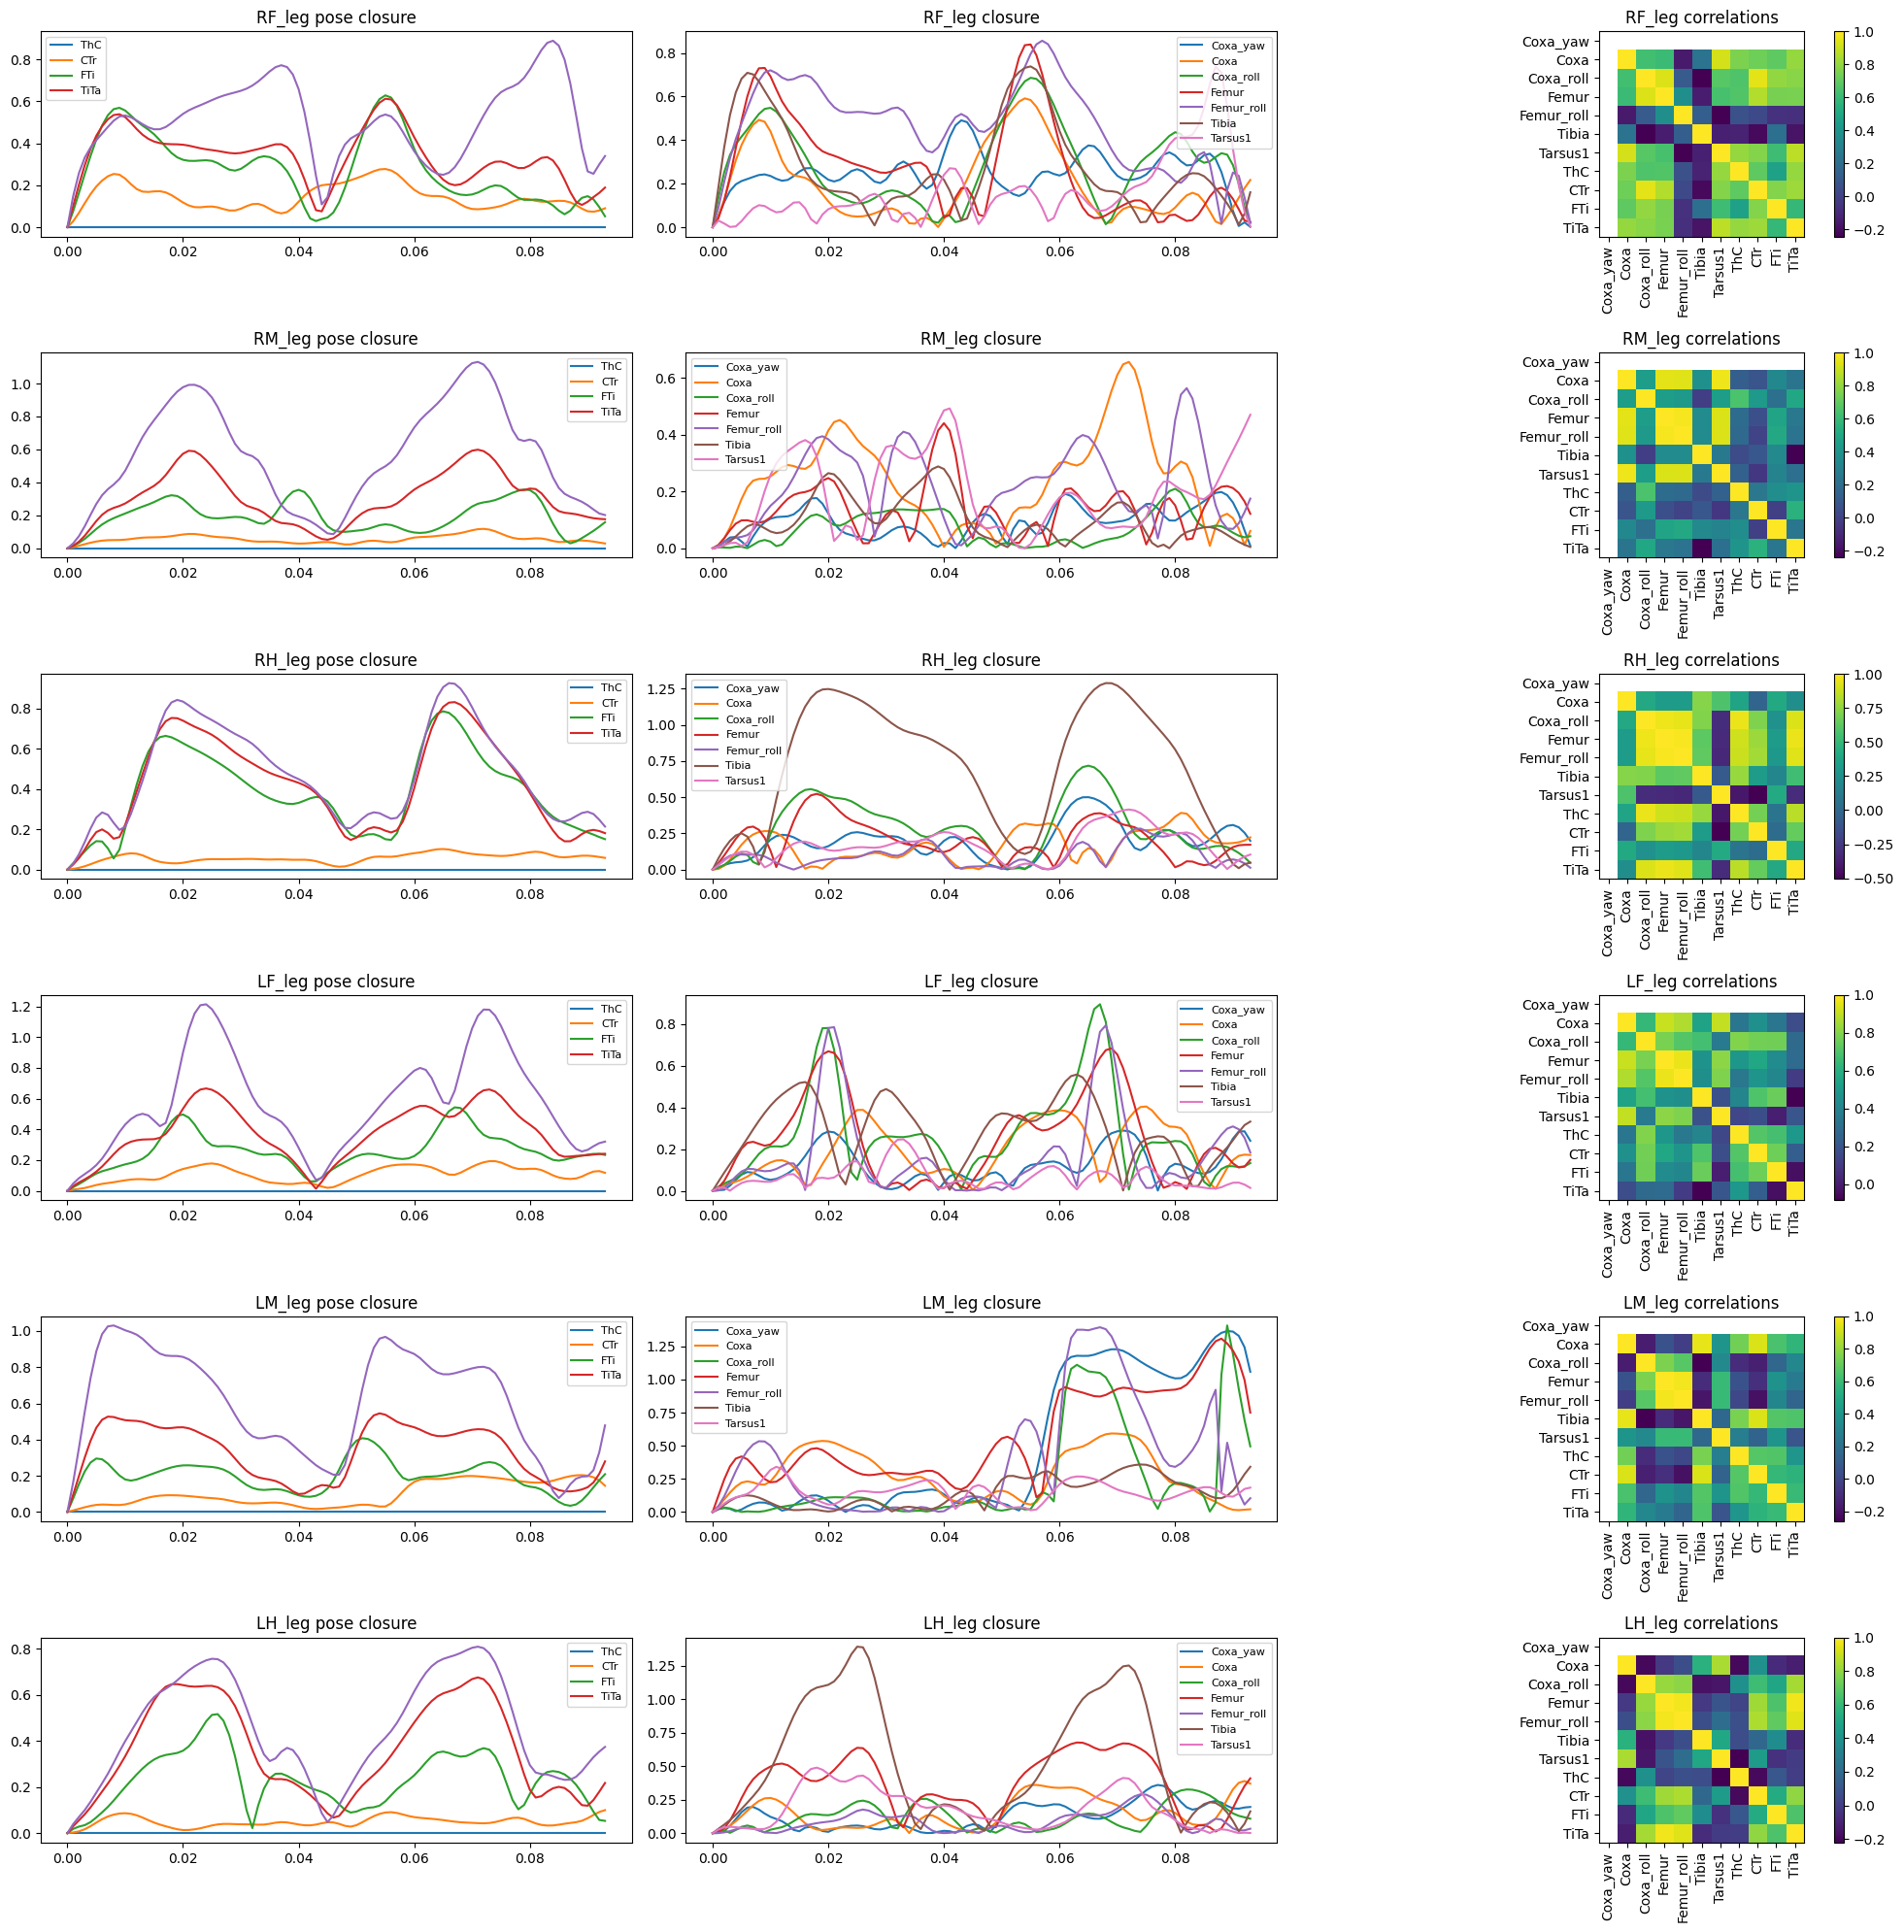

In [1038]:
# Compute distance in 3d for every leg claw (closure)
fig, axs = plt.subplots(6, 3, figsize=(20, 20))
axs = axs.flatten()
i = 0

for side in ["R", "L"]:
    for segment in ["F", "M", "H"]:
        leg_closure = np.linalg.norm(pose_data[f"{side}{segment}_leg"][0, :, :] -
                                            pose_data[f"{side}{segment}_leg"][:, :, :], axis=2)
        all_labels = dof_names + joint_names
        axs[i].plot(time, leg_closure)
        axs[i].set_title(f"{side}{segment}_leg pose closure")
        axs[i].legend(joint_names, fontsize=8)
        i += 1
        #closure in angle space
        leg_closure_angle = np.abs(formatted_angle_data[f"{side}{segment}_leg"][0, :] -
                                    formatted_angle_data[f"{side}{segment}_leg"])
        # compute pearson correlation matrix
        corr_matrix = np.zeros((len(all_labels), len(all_labels)))
        full_data = np.concatenate((leg_closure, leg_closure_angle), axis=1)
        for k in range(len(all_labels)):
            for j in range(len(all_labels)):
                corr_matrix[k, j] = np.corrcoef(full_data[:, k], full_data[:, j])[0, 1]
        axs[i].plot(time, leg_closure_angle)
        axs[i].set_title(f"{side}{segment}_leg closure")
        axs[i].legend(dof_names, fontsize=8)
        i += 1
        im = axs[i].imshow(corr_matrix)
        axs[i].set_xticks(np.arange(len(all_labels)))
        axs[i].set_yticks(np.arange(len(all_labels)))
        axs[i].set_xticklabels(all_labels, rotation=90)
        axs[i].set_yticklabels(all_labels, rotation=0)
        axs[i].set_title(f"{side}{segment}_leg correlations")
        plt.colorbar(im, ax=axs[i])
        i+=1

plt.tight_layout()
plt.show()

# Plot x y and z vs time

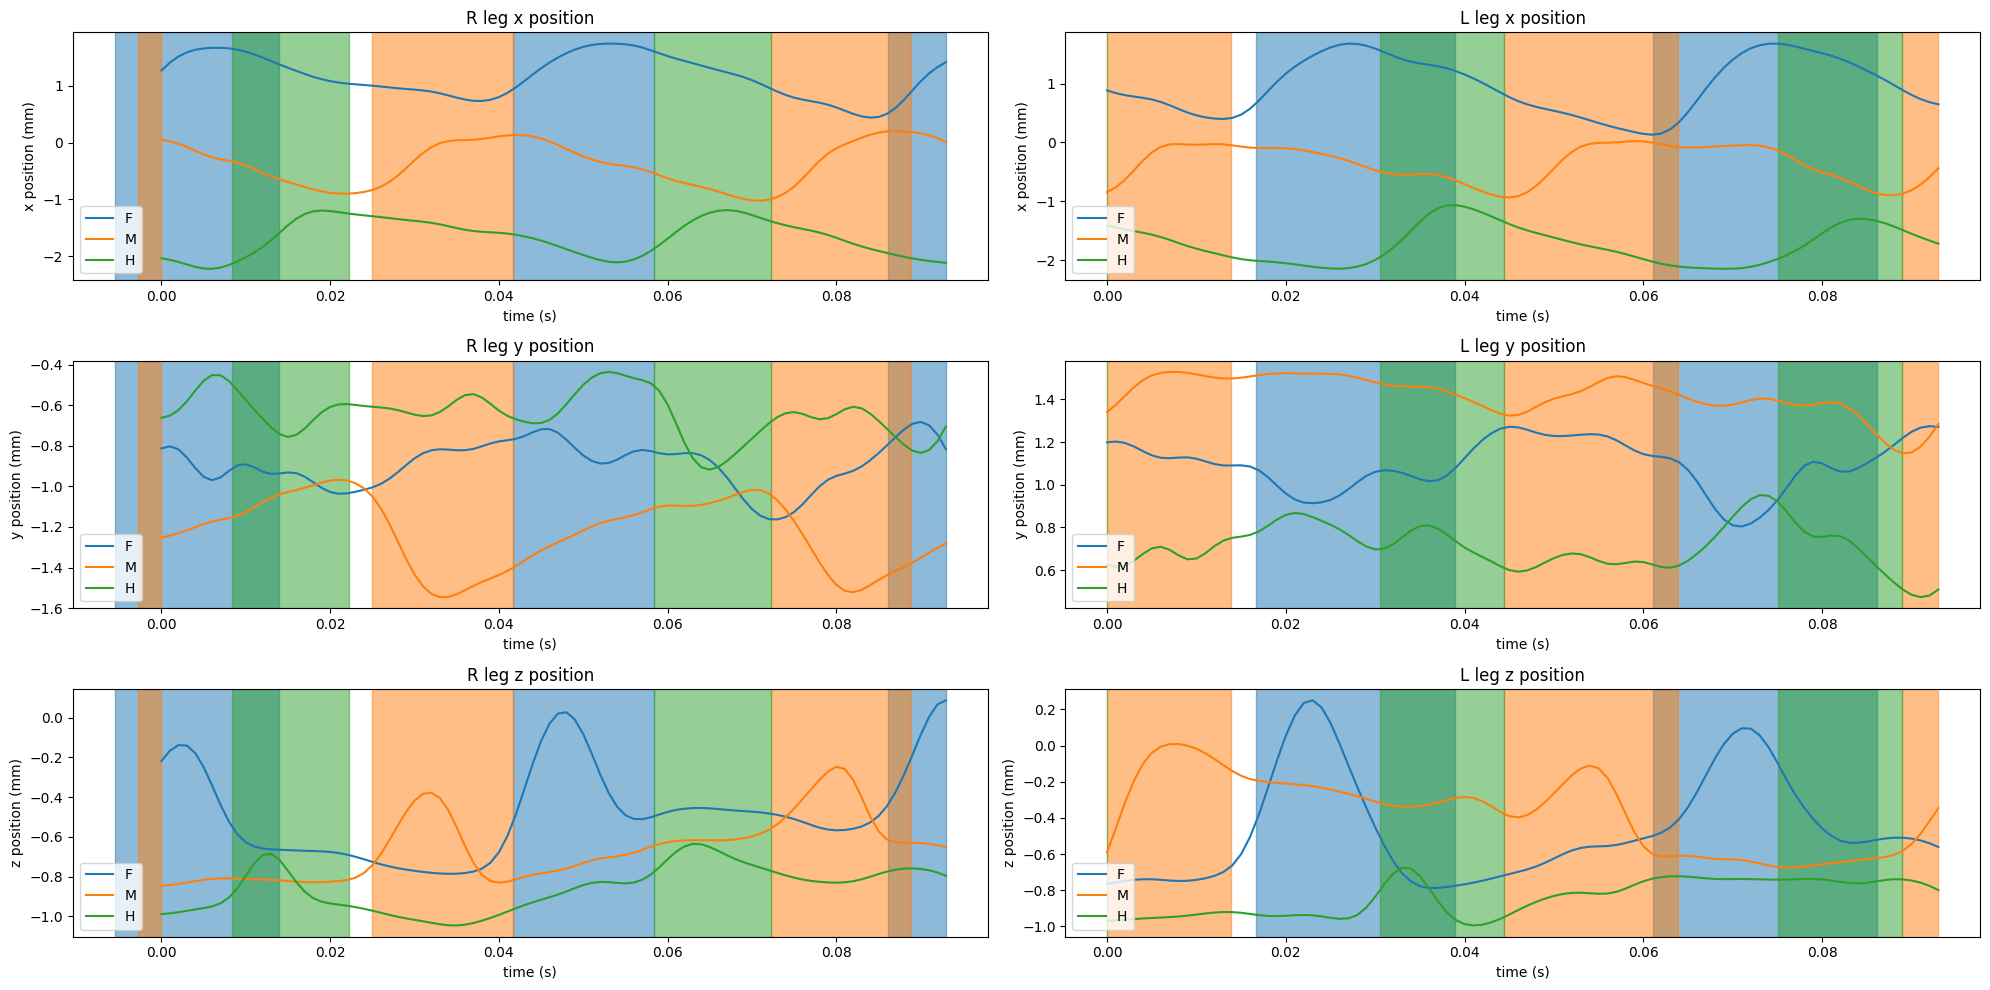

In [1039]:

fig, axs = plt.subplots(3, 2, figsize=(20, 10))
vel_thr = 0.03
colors = plt.cm.tab10.colors

for j, side in enumerate(["R", "L"]):
    for i, coord in (enumerate(["x", "y", "z"])):
        side_leg_data = []
        side_tarsus_x_vel = []
        for k, leg in enumerate(["F", "M", "H"]):
            side_leg_data.append(pose_data[f"{side}{leg}_leg"][:, -1, i])
            swing_starts = swing_stance_times[f"{side}{leg}"]["swing"]
            stance_starts = swing_stance_times[f"{side}{leg}"]["stance"]
            if swing_starts[0] > stance_starts[0]:
                swing_starts = np.insert(swing_starts, 0, 0)
            if len(swing_starts) > len(stance_starts):
                stance_starts = np.append(stance_starts, time[-1])
            for swing_start, stance_start in zip(swing_starts, stance_starts):
                axs[i][j].axvspan(swing_start, stance_start, alpha=0.5, color=colors[k])
        lines = axs[i][j].plot(time, np.array(side_leg_data).T)
        axs[i][j].set_title(f"{side} leg {coord} position")
        axs[i][j].legend(lines, ["F", "M", "H"], loc="lower left")
        axs[i][j].set_xlabel("time (s)")
        axs[i][j].set_ylabel(f"{coord} position (mm)")
    plt.tight_layout()


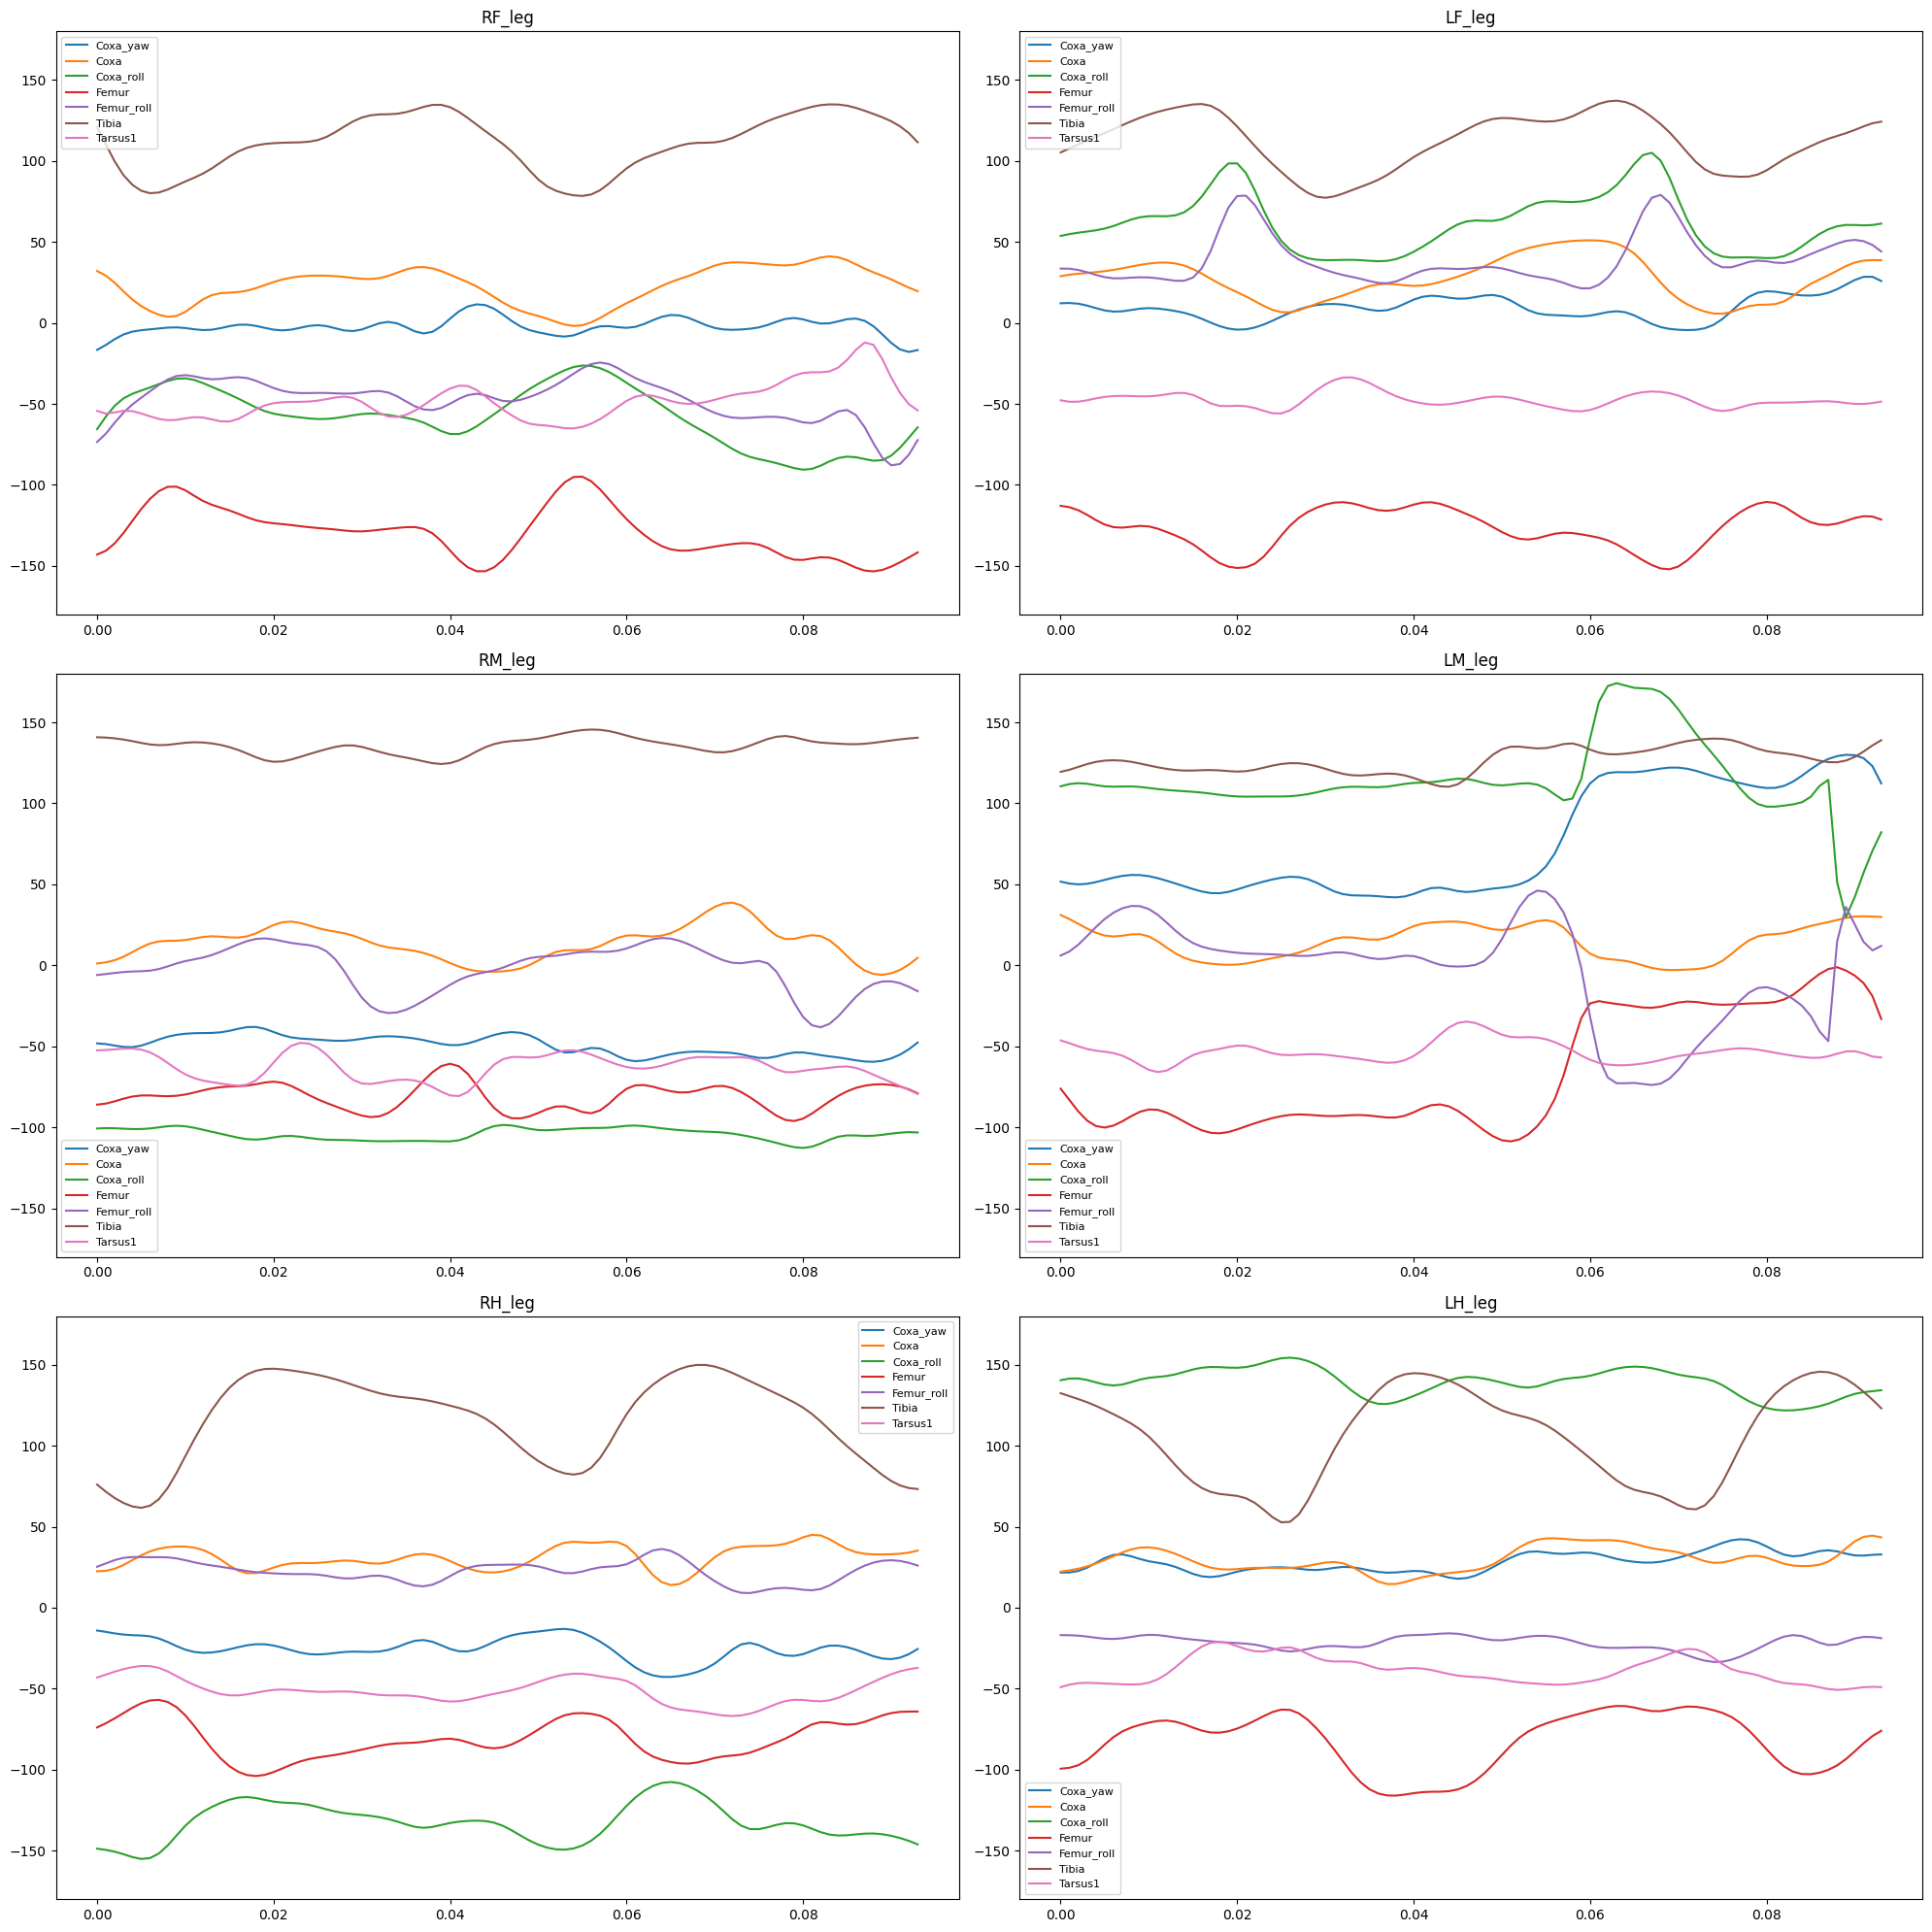

In [1040]:

fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for j, side in enumerate(["R", "L"]):
    for i, leg in enumerate(["F", "M", "H"]):
        axs[i][j].plot(time, np.rad2deg(formatted_angle_data[f"{side}{leg}_leg"]))
        axs[i][j].set_title(f"{side}{leg}_leg")
        axs[i][j].legend(dof_names, fontsize=8)
        axs[i][j].set_ylim(-180, 180)

plt.tight_layout()


# Extract steps

In [1041]:
# Extract the steps for every leg and look for the ones with maximal closure

steps_name = []
step_segmentation_criterion = []
steps_swing_limit = []
steps_stance_limit = []
steps_limit = []
segmented_steps = []
step_closures = []

for leg in ["RF_leg", "RM_leg", "RH_leg", "LF_leg", "LM_leg", "LH_leg"]:
    swing_initations_times = swing_stance_times[leg[:2]]["swing"]
    stance_starts_times = swing_stance_times[leg[:2]]["stance"]
    print(leg, swing_initations_times, stance_starts_times)
    swing_starts_idx = np.searchsorted(time, swing_initations_times, side="left")
    stance_starts_idx = np.searchsorted(time, stance_starts_times, side="right") 

    # segment swing to swing
    for i in range(len(swing_starts_idx)-1):
        steps_name.append(f"{leg[:2]}_{i}")
        step_segmentation_criterion.append("swing")
        step_start = swing_starts_idx[i]
        step_end = swing_starts_idx[i+1]
        steps_limit.append([step_start, step_end])
        # Get the stance start (e.g first idx after the swing start)
        time_distance = stance_starts_idx - step_start
        stance_start = np.min(stance_starts_idx[time_distance > 0])
        steps_swing_limit.append([0, stance_start-step_start-1])
        steps_stance_limit.append([stance_start-step_start, step_end-step_start-1])
        segmented_steps.append(formatted_angle_data[leg][step_start:step_end, :])
        step_closures.append(np.mean(np.linalg.norm(pose_data[leg][step_start, :, :] -
                                            pose_data[leg][step_end, :, :], axis=1)))
    
    # segment stance to stance
    for i in range(len(stance_starts_idx)-1):
        steps_name.append(f"{leg[:2]}_{i}")
        step_segmentation_criterion.append("stance")
        step_start = stance_starts_idx[i]
        step_end = stance_starts_idx[i+1]
        steps_limit.append([step_start, step_end])
        # Get the swing start (e.g first idx after the stance start)
        time_distance = swing_starts_idx - step_start
        swing_start = np.min(swing_starts_idx[time_distance > 0])
        steps_swing_limit.append([swing_start-step_start, step_end-step_start])
        steps_stance_limit.append([0, swing_start-step_start-1])
        segmented_steps.append(formatted_angle_data[leg][step_start:step_end, :])
        step_closures.append(np.mean(np.linalg.norm(pose_data[leg][step_start, :, :] -
                                            pose_data[leg][step_end, :, :], axis=1)))


RF_leg [-0.00555556  0.04166667  0.08611111] [0.01388889 0.05833333]
RM_leg [0.025      0.07222222] [-0.00277778  0.04166667  0.08888889]
RH_leg [0.00833333 0.05833333] [0.02222222 0.07222222]
LF_leg [0.01666667 0.06111111] [0.03888889 0.08611111]
LM_leg [0.         0.04444444 0.08888889] [0.01388889 0.06388889]
LH_leg [0.03055556 0.075     ] [0.         0.04444444 0.08888889]


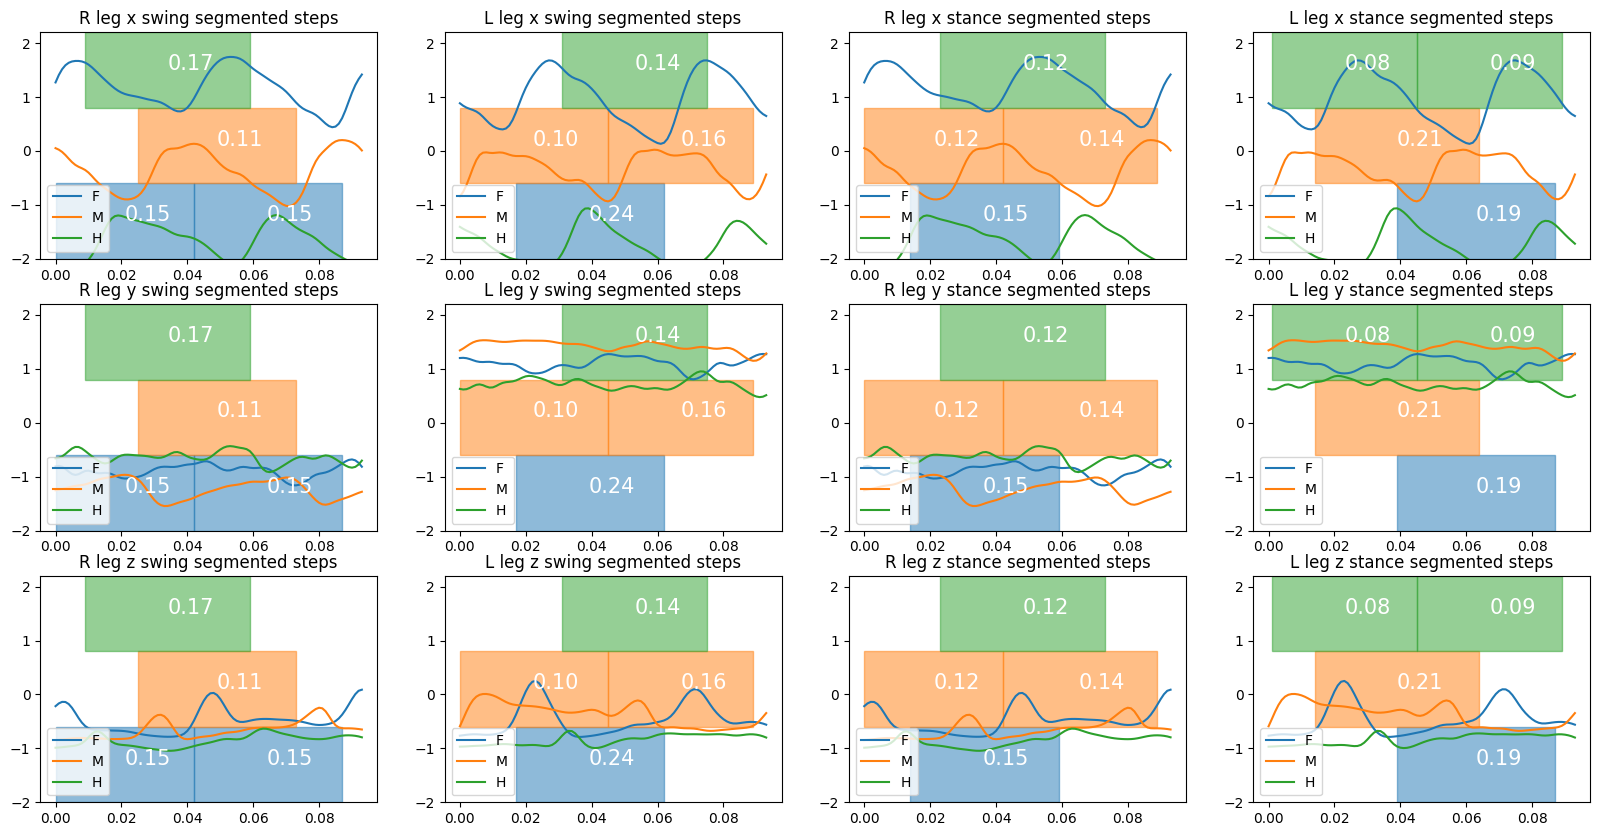

In [1042]:
# Show all this with plots for the stance and swing segmented steps
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
vel_thr = 0.03
colors = plt.cm.tab10.colors

segment = ["F", "M", "H"]
y_lim = [-2, 2.2]

for j, side in enumerate(["R", "L"]):
    for i, coord in (enumerate(["x", "y", "z"])):
        lines = []
        for k, leg in enumerate(segment):
            axs[i][j].set_title(f"{side} leg {coord} swing segmented steps")
            line = axs[i][j].plot(time, pose_data[f"{side}{leg}_leg"][:, -1, i], color=colors[k])
            lines.append(line)
            axs[i][j].set_ylim(y_lim)
            axs[i][j+2].set_title(f"{side} leg {coord} stance segmented steps")
            axs[i][j+2].plot(time, pose_data[f"{side}{leg}_leg"][:, -1, i], color=colors[k])
            axs[i][j+2].set_ylim(y_lim)

            for n, name in enumerate(steps_name):
                plot_offset = 0 if step_segmentation_criterion[n] == "swing" else 2
                ymin = k*1/len(segment)
                ymax = ymin + 1/len(segment)
                text_y_pos = np.mean([ymin, ymax])*np.diff(y_lim) + y_lim[0]
                if name.startswith(f"{side}{leg}"):
                    middle = int(np.mean(steps_limit[n]))
                    axs[i][j+plot_offset].axvspan(time[steps_limit[n][0]], time[steps_limit[n][1]], alpha=0.5, color=colors[k], ymin=ymin, ymax=ymax)
                    axs[i][j+plot_offset].text(time[middle], text_y_pos, f"{step_closures[n]:.2f}", fontsize=15, color="white")
        lines = np.array(lines).flatten()
        axs[i][j].legend(lines, ["F", "M", "H"], loc = "lower left")
        axs[i][j+2].legend(lines, ["F", "M", "H"], loc = "lower left")

Let's make the extracted steps symmetrical do some timewarping so that they last for the same duration and interpolate to ensure closure of the steps
Then we should try all the combinations between the segmented steps

# Time warp the data so that they have the same length

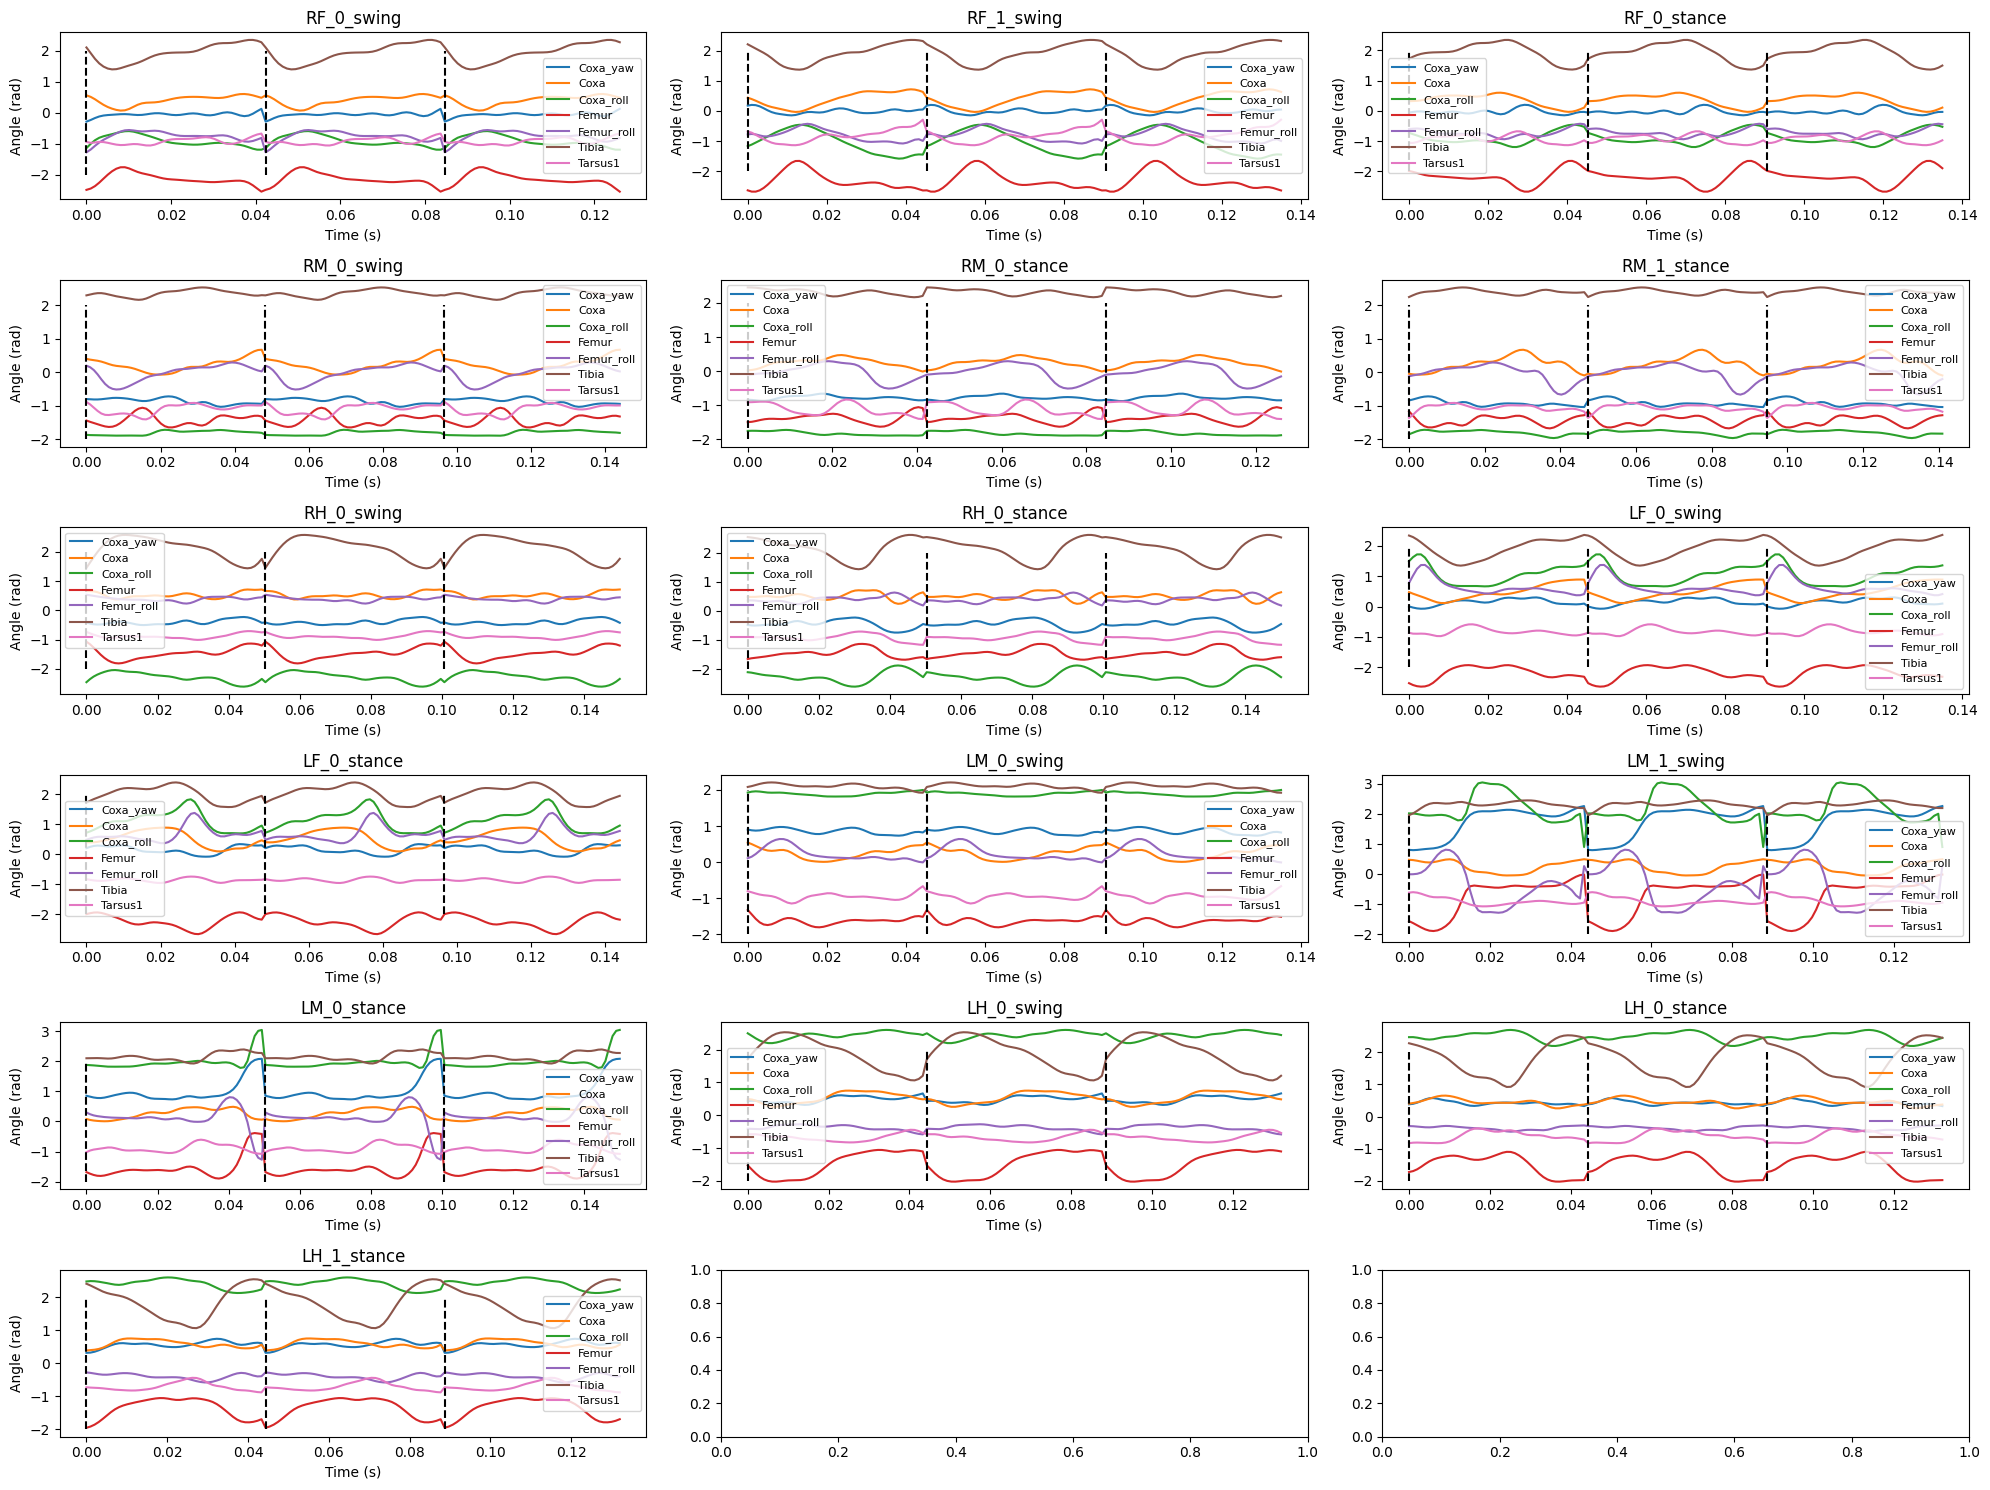

In [1043]:
# Take the median length as the target step length for every step

n_plots = len(steps_name)
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))   
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axs = axs.flatten()

def loop_data(data, n_loops):
    if len(data.shape) == 1:
        return np.tile(data, n_loops)
    else:
        return np.tile(data, (n_loops, 1)).T
    
n_loops = 3
 
for i in range(len(steps_name)):
    step_length = steps_limit[i][1] - steps_limit[i][0]
    looped_data = loop_data(segmented_steps[i], n_loops).T
    looped_time = np.linspace(0, len(looped_data)*timestep, len(looped_data))

    axs[i].plot(looped_time, looped_data)
    axs[i].vlines(looped_time[np.arange(0, step_length*n_loops, step_length)],
                   -2, 2, color="black", linestyle="--")
    axs[i].set_title(f"{steps_name[i]}_{step_segmentation_criterion[i]}")
    axs[i].set_ylabel("Angle (rad)")
    axs[i].set_xlabel("Time (s)")
    axs[i].legend(dof_names, fontsize=8)

plt.tight_layout()
plt.show()


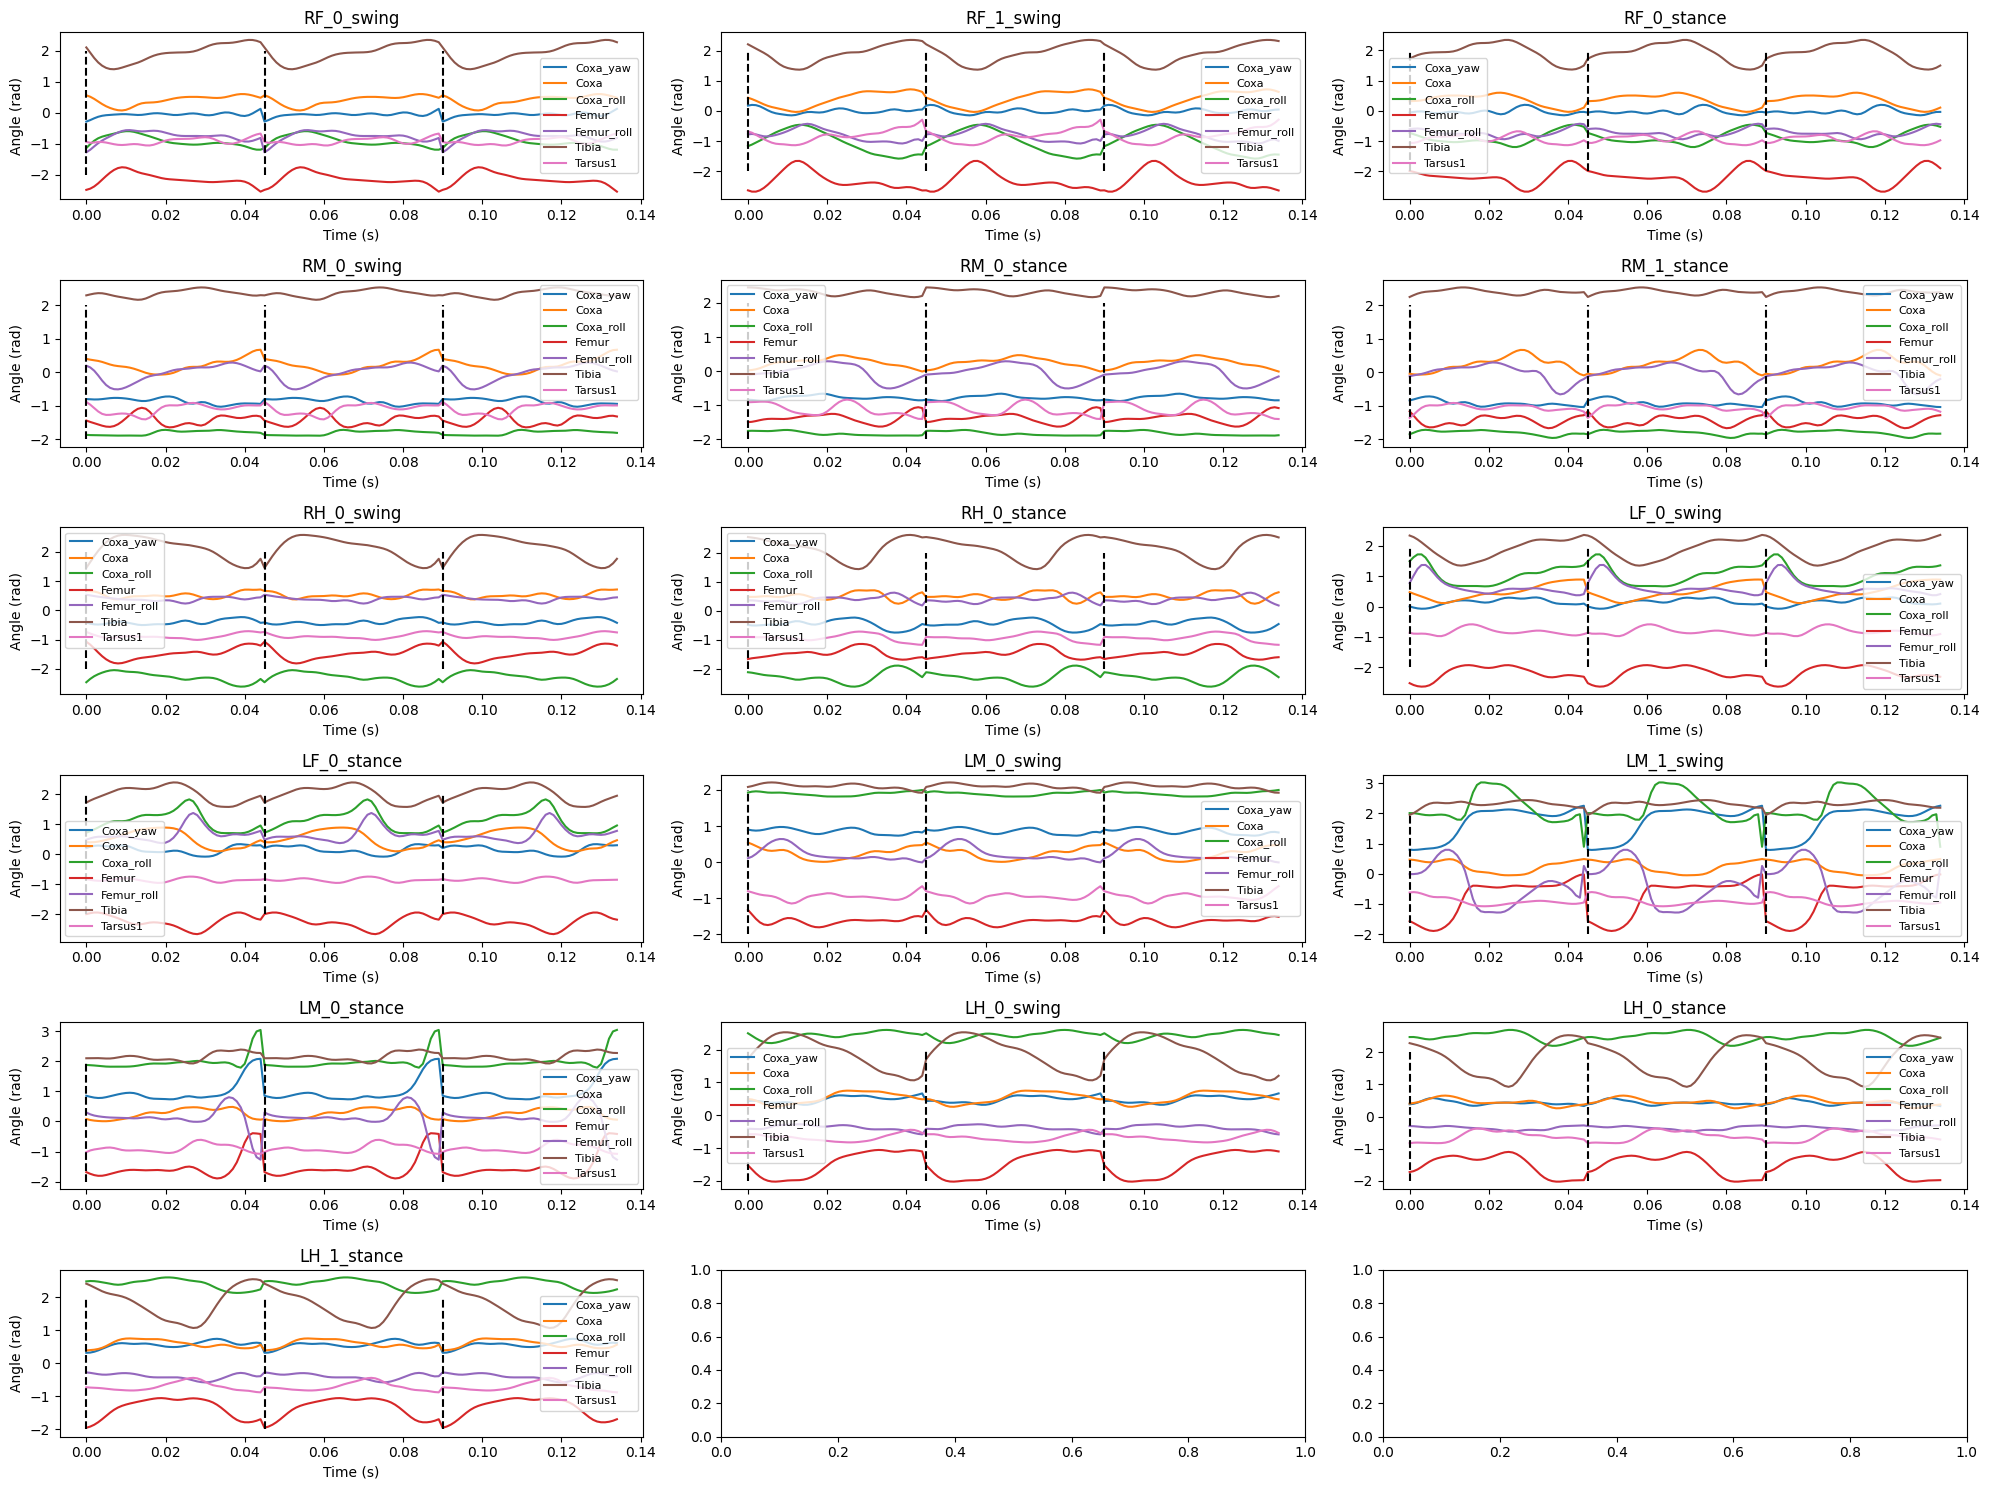

In [1044]:
# Take the median length as the target step length for every step
target_step_length = np.median(np.diff(steps_limit, axis=1)).astype(int)
wrapped_steps = []

n_plots = len(steps_name)
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))   
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axs = axs.flatten()

def loop_data(data, n_loops):
    if len(data.shape) == 1:
        return np.tile(data, n_loops)
    else:
        return np.tile(data, (n_loops, 1)).T
    
n_loops = 3
looped_time = np.arange(0, target_step_length*n_loops*timestep, timestep)
 
for i in range(len(steps_name)):
    step_length = steps_limit[i][1] - steps_limit[i][0]
    old_t = time[steps_limit[i][0]:steps_limit[i][1]]
    new_t = np.linspace(old_t[0], old_t[-1], target_step_length)
    n_pts, n_dofs = segmented_steps[i].shape
    wrapped_angle_data = np.zeros((target_step_length, n_dofs))
    for j in range(n_dofs):
        wrapped_angle_data[:, j] = np.interp(new_t, old_t, segmented_steps[i][:, j])
    wrapped_steps.append(wrapped_angle_data)

    # We need to modify the swing and stance limits to match the new time
    steps_swing_limit[i] = steps_swing_limit[i]/step_length*target_step_length
    steps_stance_limit[i] = steps_stance_limit[i]/step_length*target_step_length
    if step_segmentation_criterion[i] == "swing":
        #make the swing longer finish later
        steps_swing_limit = np.ceil(steps_swing_limit).astype(int)
        steps_stance_limit = np.ceil(steps_stance_limit).astype(int)
        steps_swing_limit[i][0] = 0
        steps_stance_limit[i][1] = target_step_length
        steps_stance_limit[i][0] = steps_swing_limit[i][1] + 1
    elif step_segmentation_criterion[i] == "stance":
        #make the swing longer start earlier
        steps_swing_limit = np.floor(steps_swing_limit).astype(int)
        steps_stance_limit = np.floor(steps_stance_limit).astype(int)
        steps_swing_limit[i][1] = target_step_length
        steps_stance_limit[i][0] = 0
        steps_stance_limit[i][1] = steps_swing_limit[i][0] - 1

    axs[i].plot(looped_time, loop_data(wrapped_steps[i], n_loops).T)
    axs[i].vlines(looped_time[np.arange(0, target_step_length*n_loops, target_step_length)],
                   -2, 2, color="black", linestyle="--")
    axs[i].set_title(f"{steps_name[i]}_{step_segmentation_criterion[i]}")
    axs[i].legend(dof_names, fontsize=8)
    axs[i].set_ylabel("Angle (rad)")
    axs[i].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


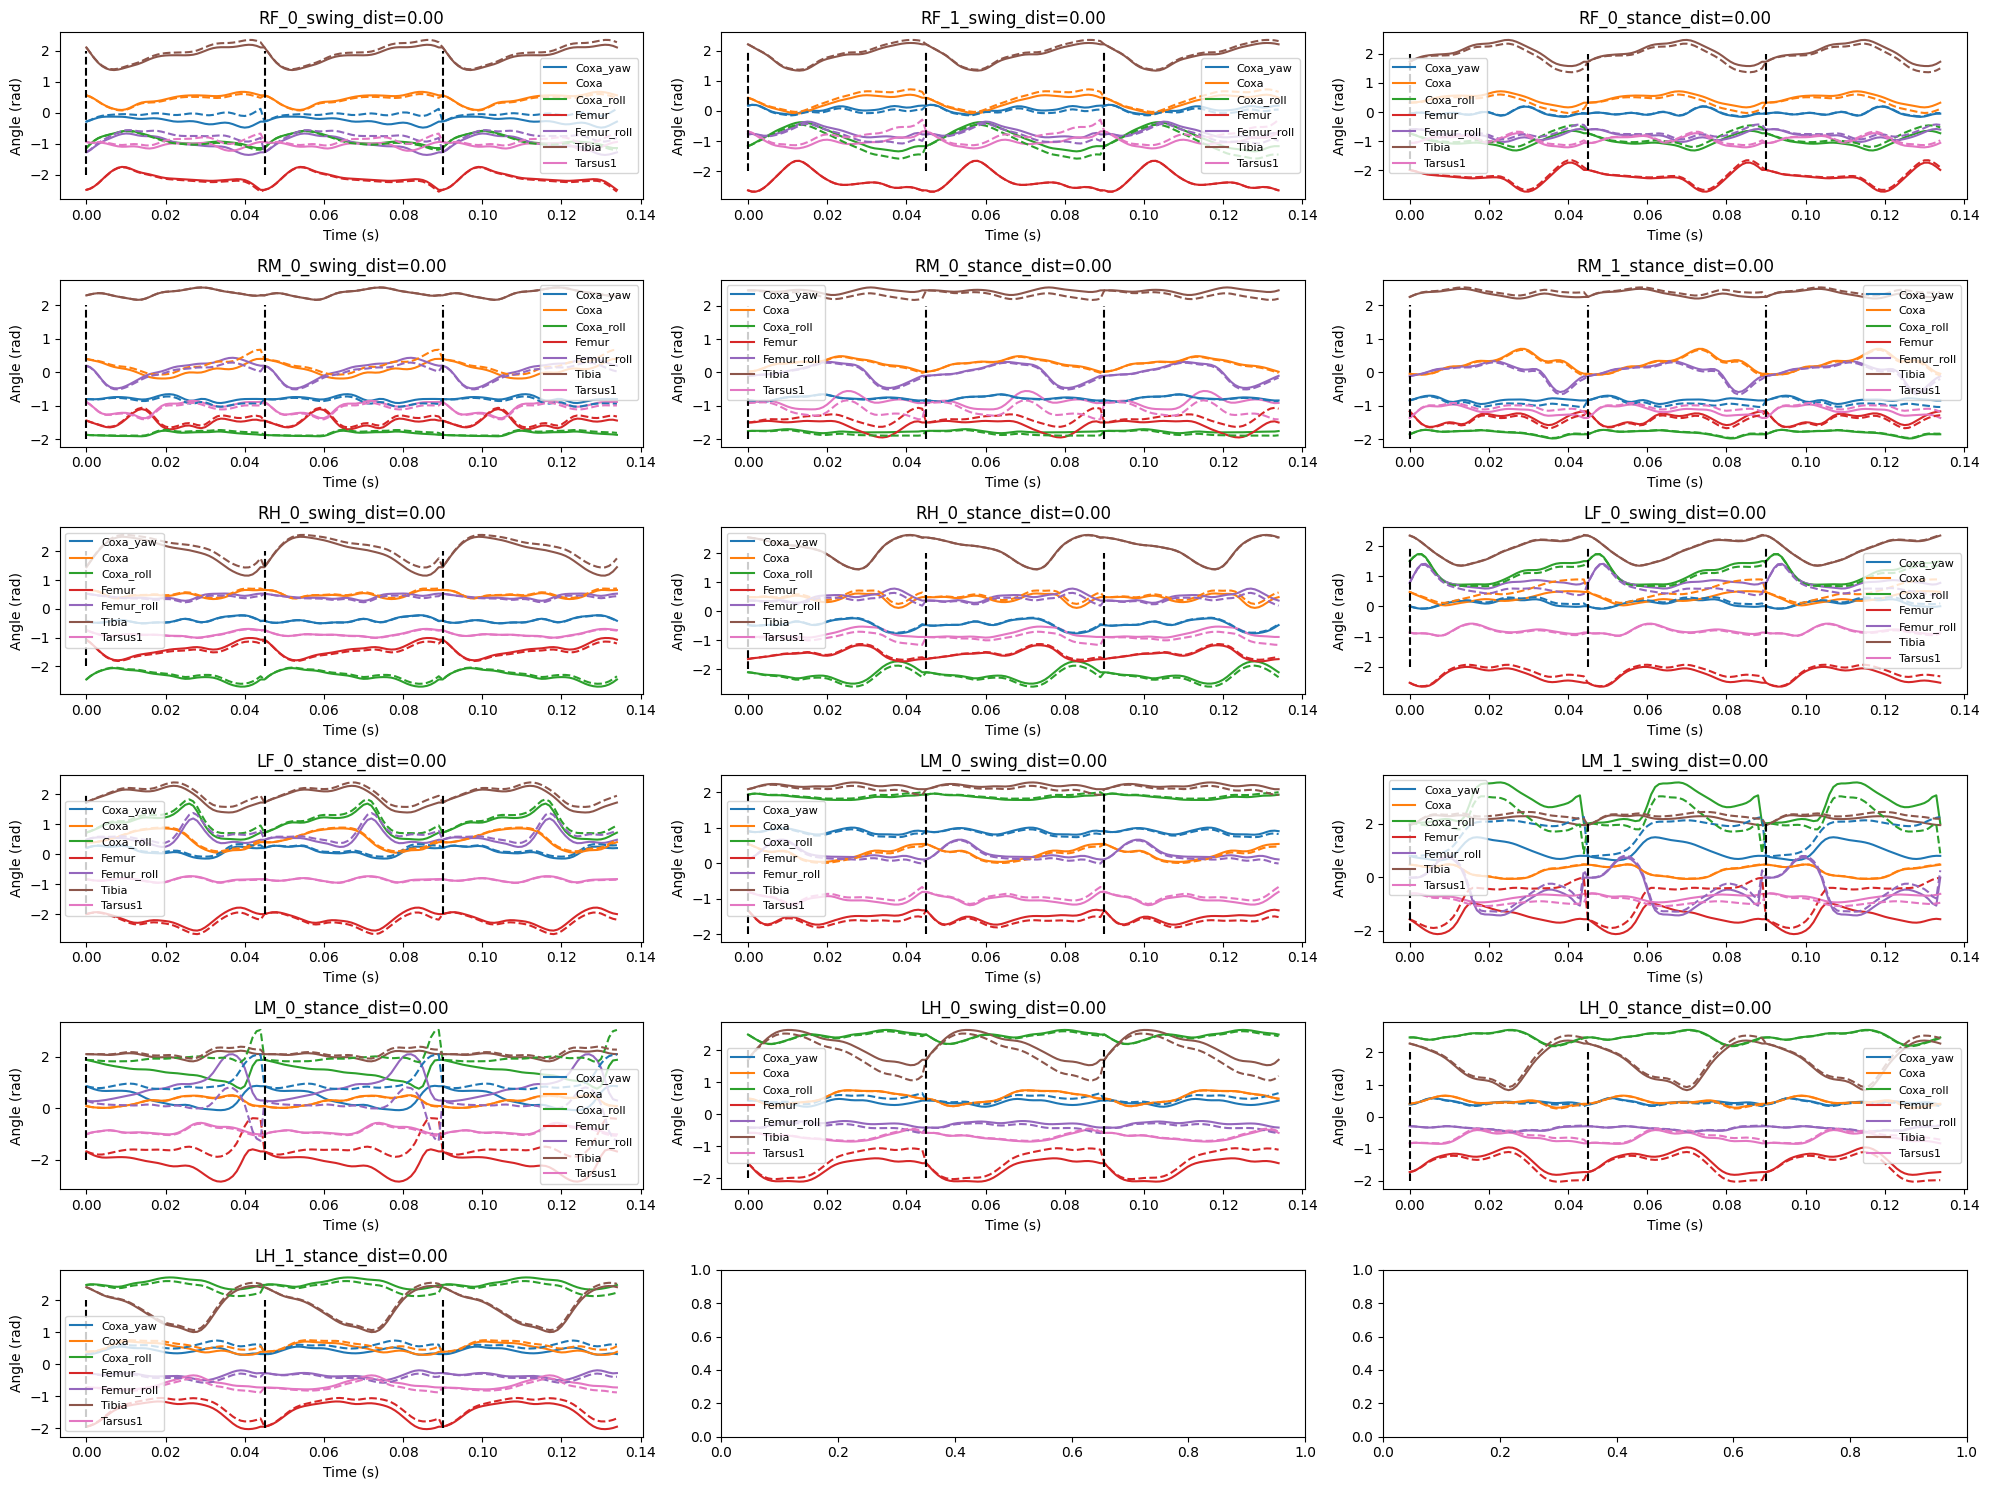

(16, 45, 7)

In [1045]:
# In the last 10% of the data add an increasing offset to the data to ensure closure

interp_percentage = 1.0
n_interp_steps = np.floor(interp_percentage*target_step_length).astype(int)


interp_steps = []

n_plots = len(steps_name)
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))   
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axs = axs.flatten()

for i in range(len(steps_name)):
    n_pts, n_dofs = wrapped_steps[i].shape
    interp_angle_data = np.zeros((target_step_length, n_dofs))
    for j in range(n_dofs):
        interp_angle_data[:, j] = wrapped_steps[i][:, j]
        # interpolate on the difference and add it to the actual values
        missmatch = wrapped_steps[i][0, j] - wrapped_steps[i][-1, j]
        diff_vect = np.linspace(0, missmatch, n_interp_steps)
        interp_angle_data[-n_interp_steps:, j] += diff_vect
    interp_steps.append(interp_angle_data)


    axs[i].plot(looped_time, loop_data(interp_steps[i], n_loops).T)
    #reset color cycle
    axs[i].set_prop_cycle(None)
    axs[i].plot(looped_time, loop_data(wrapped_steps[i], n_loops).T, linestyle="--")
    distance = np.max(interp_steps[i][-1, :]-interp_steps[i][0, :])
    axs[i].set_title(f"{steps_name[i]}_{step_segmentation_criterion[i]}_dist={distance:.2f}")
    axs[i].vlines(looped_time[np.arange(0, target_step_length*n_loops, target_step_length)],
                   -2, 2, color="black", linestyle="--")
    axs[i].legend(dof_names, fontsize=8)
    axs[i].set_ylabel("Angle (rad)")
    axs[i].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

interp_steps = np.array(interp_steps)
interp_steps.shape

28 45 0 27 45
26 45 0 25 45
29 45 0 28 45
32 45 0 31 45
21 45 0 20 45
27 45 0 26 45
30 45 0 29 45
30 45 0 29 45


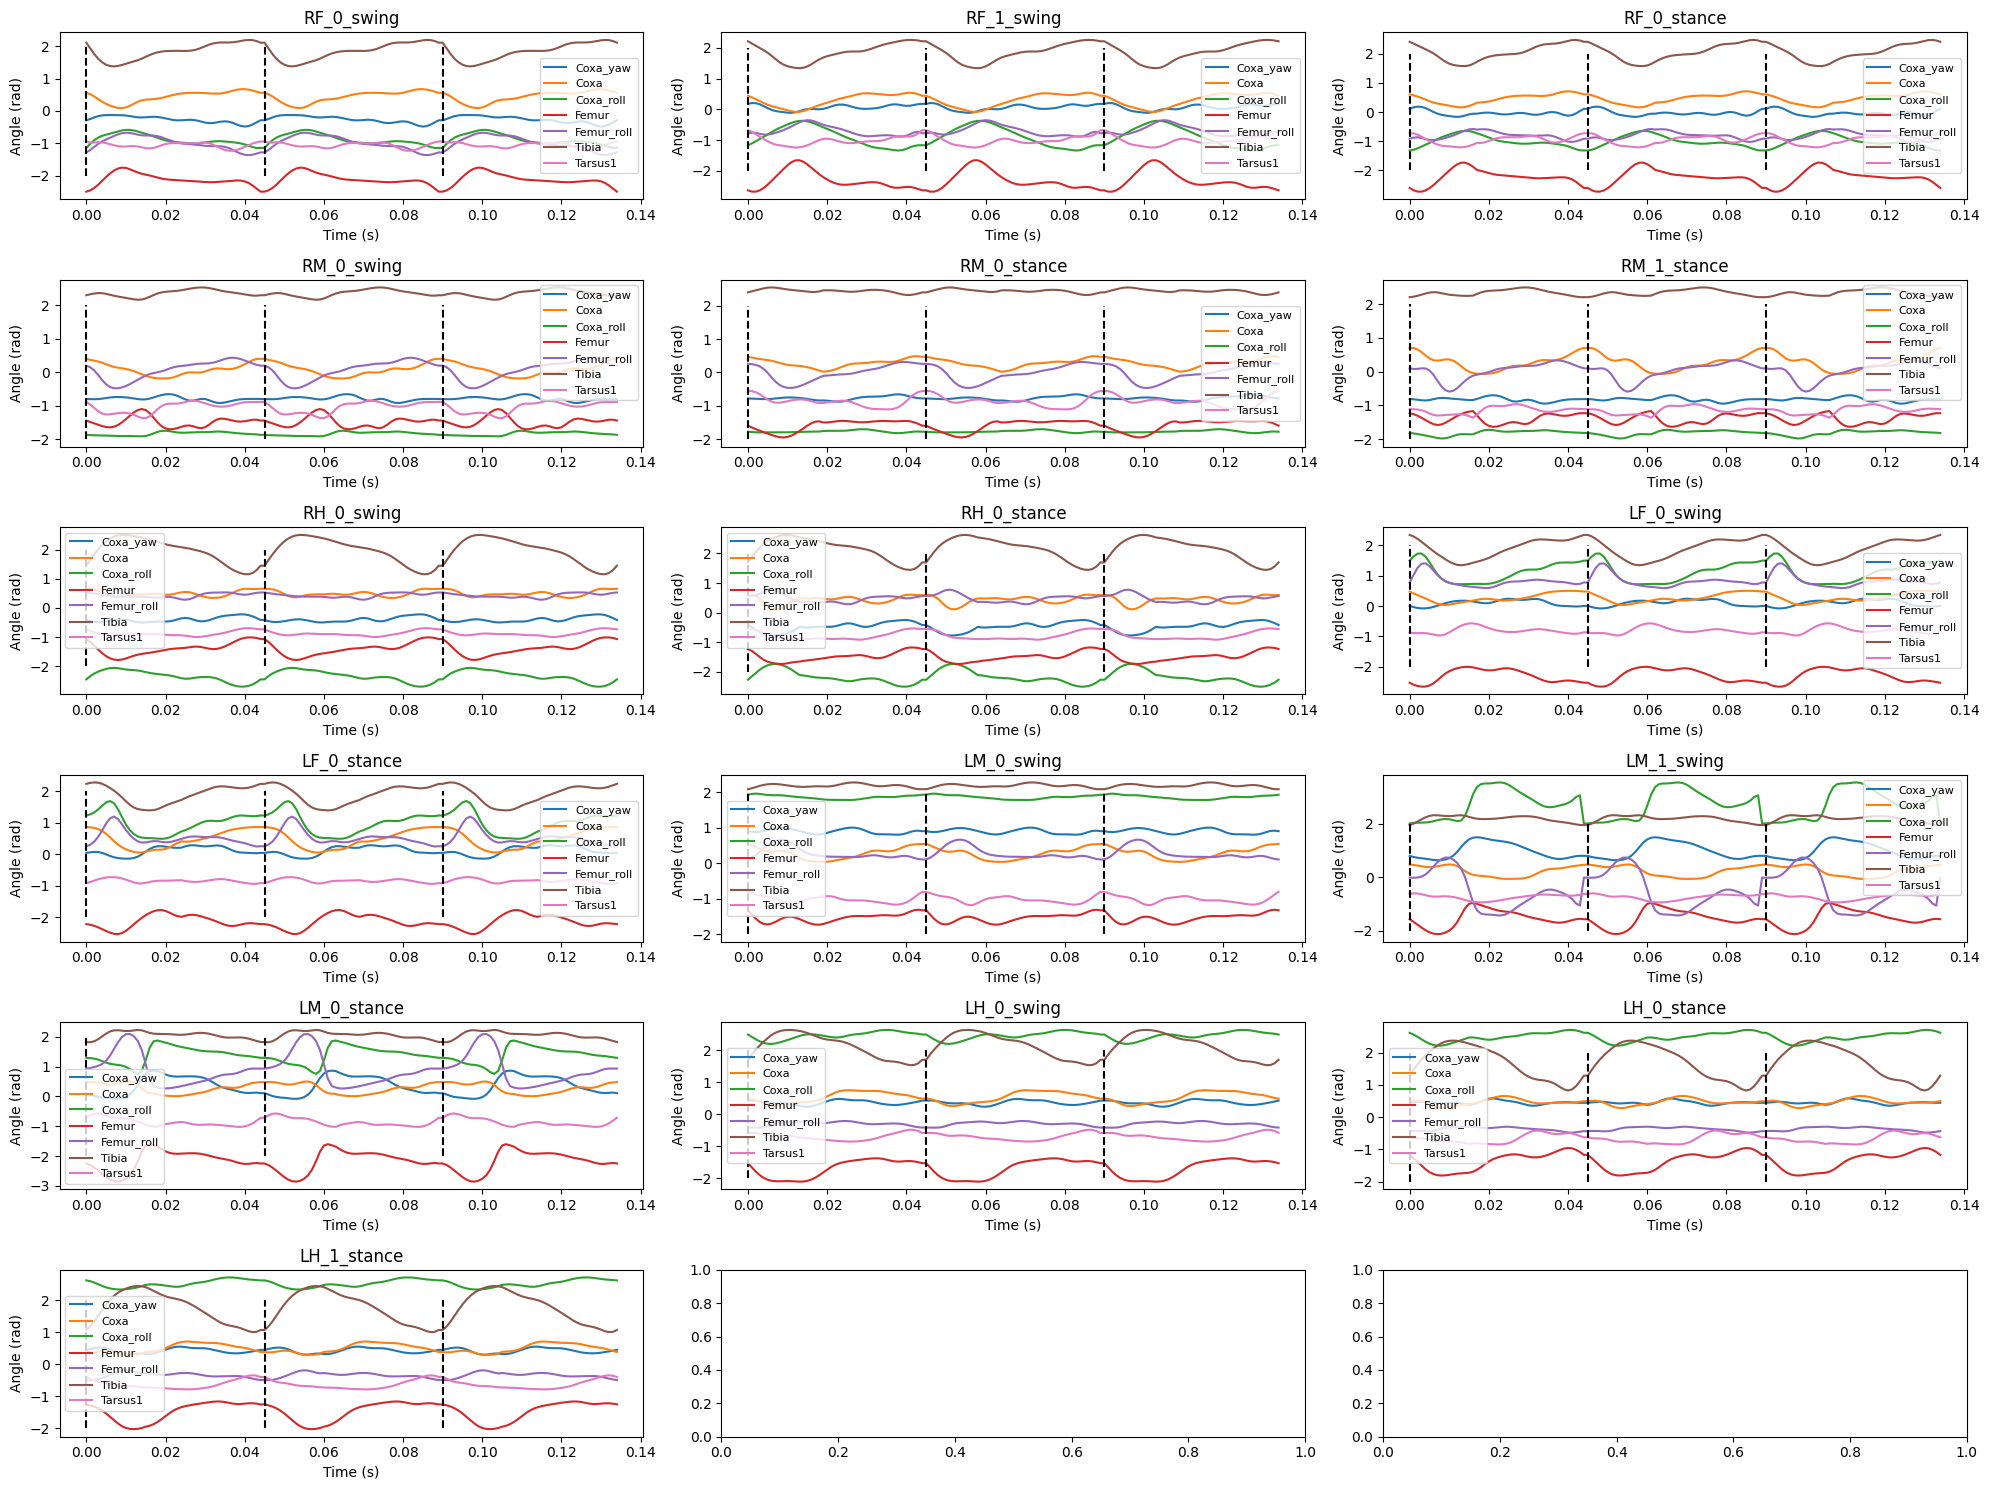

In [1046]:
# Lets invert the order of the stance and swing phase in the stance segmented steps
swingfirst_steps = []

n_plots = len(steps_name)
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))   
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axs = axs.flatten()

for i in range(len(steps_name)):
    if step_segmentation_criterion[i] == "stance":
        swing_start, swing_end = steps_swing_limit[i]
        swing_dur = swing_end - swing_start
        stance_start, stance_end = steps_stance_limit[i]
        stance_dur = stance_end - stance_start
        swingfirst_step = np.zeros_like(interp_steps[i])
        print(swing_start, swing_end, stance_start, stance_end, target_step_length)
        assert swing_dur + stance_dur == target_step_length-1, f"swing and stance duration should sum to the step duration (here {target_step_length} vs {swing_dur + stance_dur}sum)"
        assert swing_start == stance_end + 1, "swing should start right after stance"
        assert stance_start == 0, "stance should start at the beginning of the step"
        assert swing_end == target_step_length, "swing should end at the end of the step"
        swingfirst_step[:swing_dur+1, :] = interp_steps[i][stance_end:swing_end+1, :]
        swingfirst_step[swing_dur:, :] = interp_steps[i][:stance_end+1, :]
        swingfirst_steps.append(swingfirst_step)
        steps_swing_limit[i] = [0, swing_dur-1]
        steps_stance_limit[i] = [swing_dur, target_step_length-1]
    else:
        swingfirst_steps.append(interp_steps[i])

    axs[i].plot(looped_time, loop_data(swingfirst_steps[i], n_loops).T)
    axs[i].vlines(looped_time[np.arange(0, target_step_length*n_loops, target_step_length)],
                   -2, 2, color="black", linestyle="--")
    axs[i].set_title(f"{steps_name[i]}_{step_segmentation_criterion[i]}")
    axs[i].legend(dof_names, fontsize=8)
    axs[i].set_ylabel("Angle (rad)")
    axs[i].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()
    

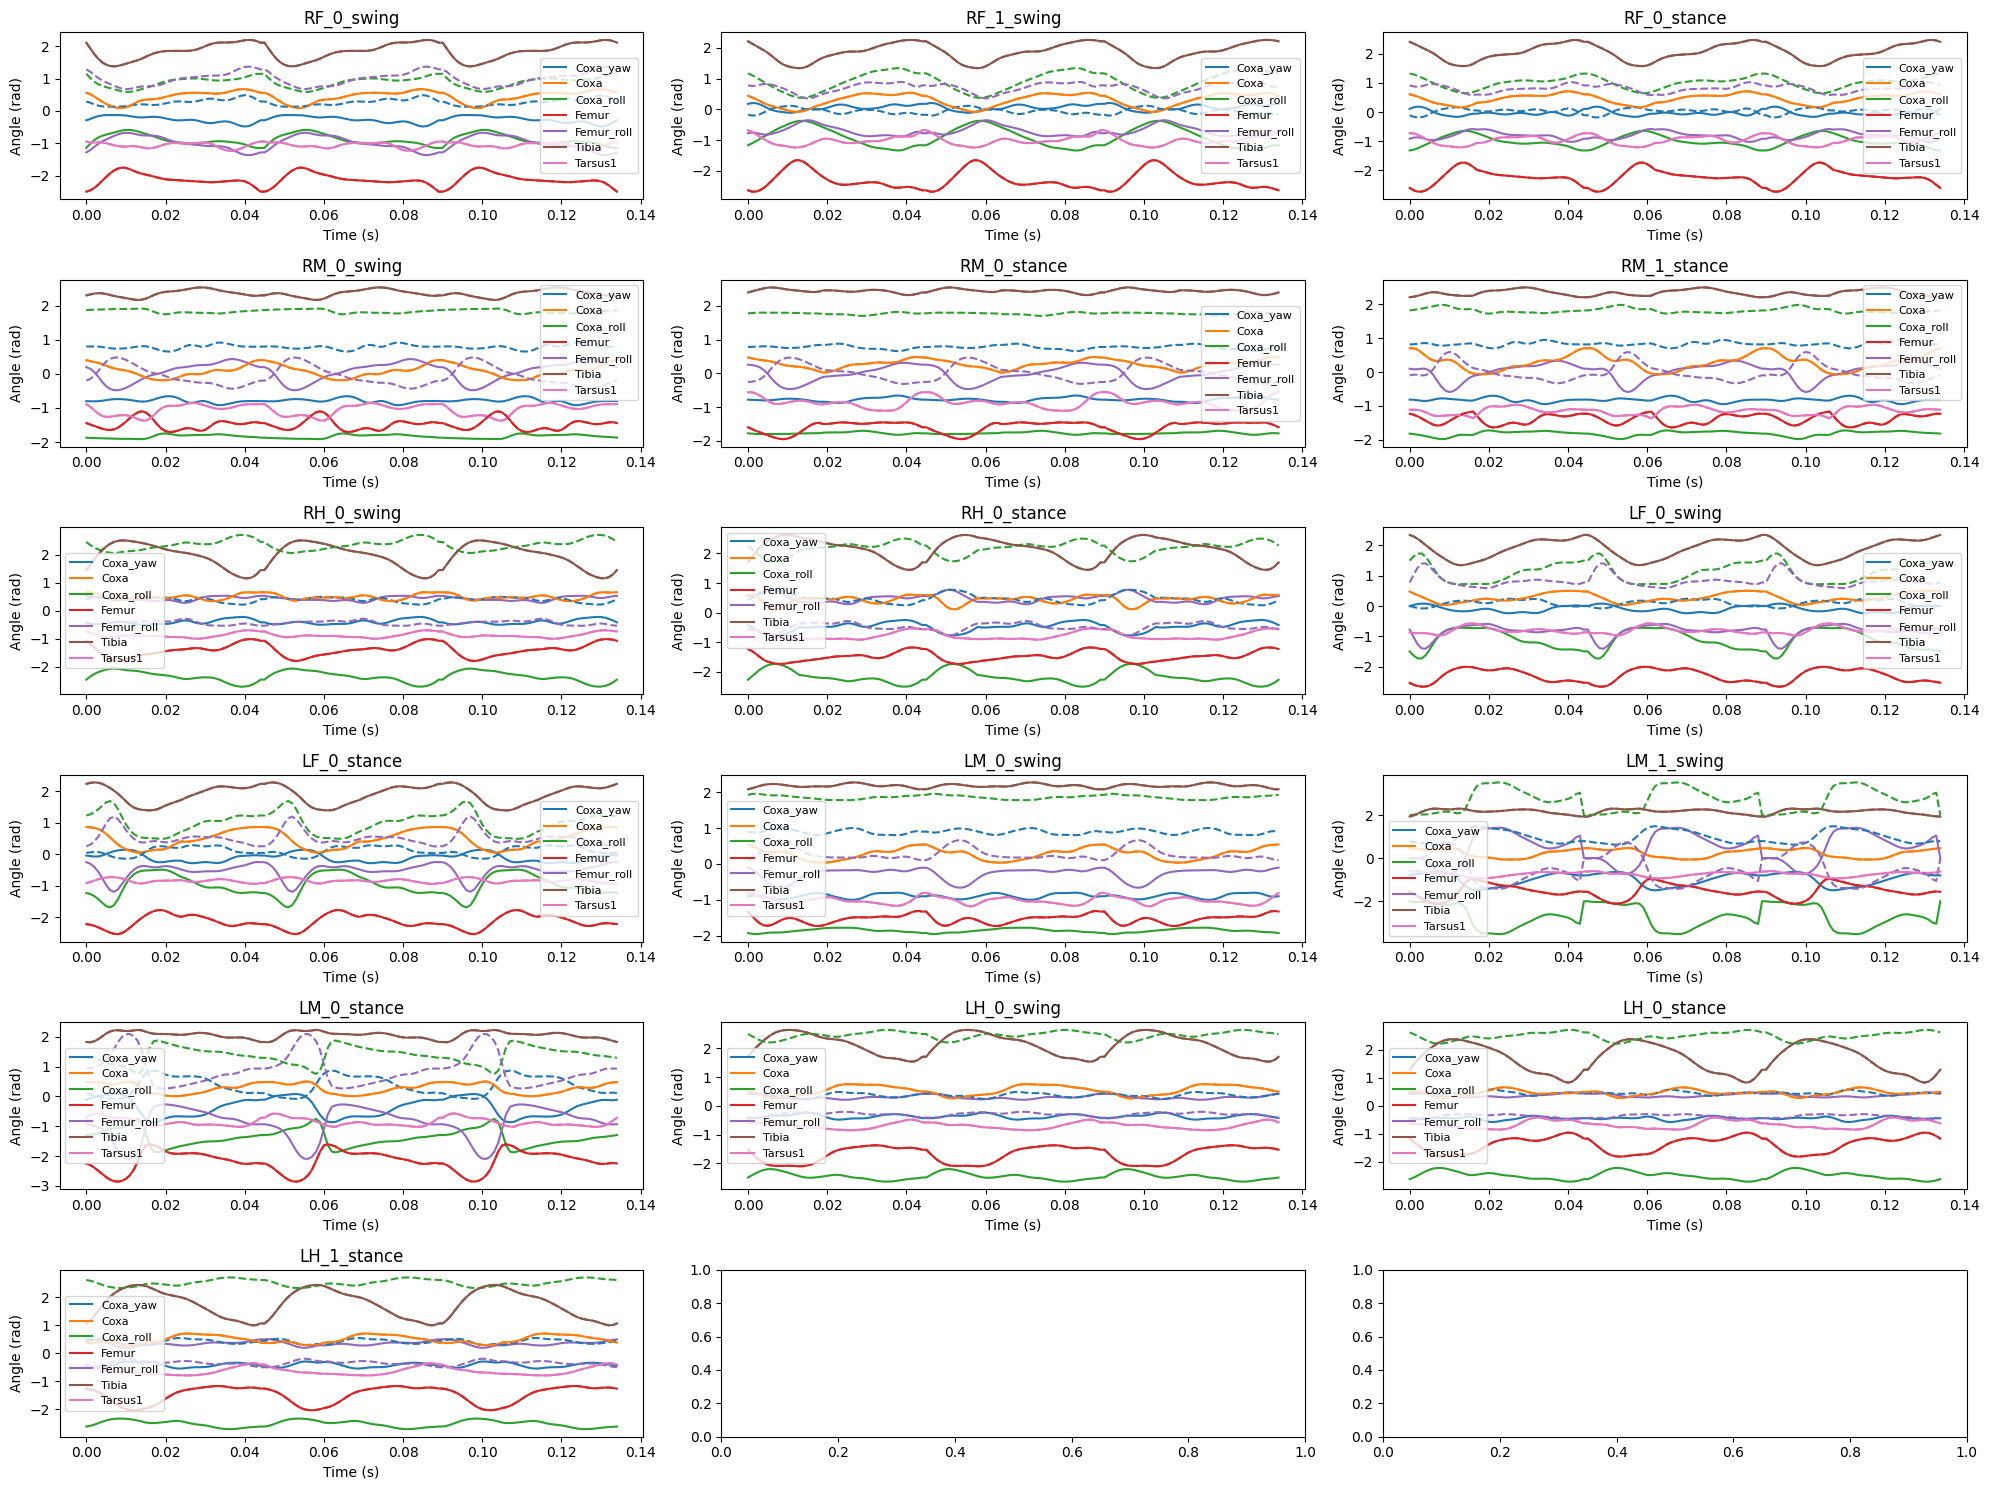

(16, 2, 45, 7)

In [1047]:
# Make each of those angles symmetric
# E.g invert every roll or yaw degree of freedom¨

symmetric_steps = []

roll_or_yaw_angles = np.array([1 if "roll" in angle or "yaw" in angle else 0 for angle in dof_names]).astype(bool)
inversion_factor = np.ones(len(dof_names))
inversion_factor[roll_or_yaw_angles] = -1

n_plots = len(steps_name)
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))   
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axs = axs.flatten()

for i in range(len(steps_name)):
    bilat_step_dataset = []
    if steps_name[i].startswith("R"):
        bilat_step_dataset.append(swingfirst_steps[i])
        bilat_step_dataset.append(swingfirst_steps[i]*np.tile(inversion_factor, (swingfirst_steps[i].shape[0], 1)))
    else:
        bilat_step_dataset.append(swingfirst_steps[i]*np.tile(inversion_factor, (swingfirst_steps[i].shape[0], 1)))
        bilat_step_dataset.append(swingfirst_steps[i])
    symmetric_steps.append(bilat_step_dataset)

    for k in range(2):
        linestype = "-" if k == 0 else "--"
        axs[i].plot(looped_time, loop_data(symmetric_steps[i][k], n_loops).T, linestyle=linestype)
        if k == 0:
            axs[i].legend(dof_names, fontsize=8)
            axs[i].set_title(f"{steps_name[i]}_{step_segmentation_criterion[i]}")
        # reset the color cycle
        axs[i].set_prop_cycle(None)
        axs[i].set_ylabel("Angle (rad)")
        axs[i].set_xlabel("Time (s)")
        
plt.tight_layout()
plt.show()

symmetric_steps = np.array(symmetric_steps)
symmetric_steps.shape

In [1048]:
# Modify the tarsus pitch angle

tarsus_step = []
for i in range(len(steps_name)):
    
    tarsus_step.append(symmetric_steps[i].copy())
    tarsus_step[i][:, : , -1] += np.pi/10
    tarsus_step[i][:, : , -2] -= np.pi/10
    if "H" in steps_name[i]:
        tarsus_step[i][:, : , -1] += np.pi/10

tarsus_step = np.array(tarsus_step)
tarsus_step.shape

(16, 2, 45, 7)

In [1049]:
import os
single_step_path = data_path.parent / f"single_step_datasets"
# remove the file if exists
if single_step_path.exists():
    os.system(f"rm -rf {single_step_path}")
single_step_path.mkdir(exist_ok=False)

swing_stance_margin = 0
closure_thr = [0.17, 0.12, 0.17]

# format and generate different step datasets
segment_step_names_index = {"F":0, "M":1, "H":2}
segment_step_names_groups = [[], [], []]
for i, name in enumerate(steps_name):
    if step_closures[i] <= closure_thr[segment_step_names_index[name[1]]] and not "LM" in name:
        segment_step_names_groups[segment_step_names_index[name[1]]].append(i)

print(segment_step_names_groups)
assert segment_step_names_groups[0], "No front leg steps found"
assert segment_step_names_groups[1], "No middle leg steps found"
assert segment_step_names_groups[2], "No hind leg steps found"

# Take one index from each segment 
import itertools
for F_id, M_id, H_id in itertools.product(segment_step_names_groups[0], segment_step_names_groups[1], segment_step_names_groups[2]):
    single_step_data = {}
    single_step_data["swing_stance_time"] = {"swing":{}, "stance":{}}
    F_data = tarsus_step[F_id]
    M_data = tarsus_step[M_id]
    H_data = tarsus_step[H_id]
    for segment, seg_data in zip(["F", "M", "H"], [F_data, M_data, H_data]):
        for side, side_data in zip(["R", "L"], seg_data):
            for dof, dof_data in zip(dof_names, side_data.T):
                single_step_data[f"joint_{side}{segment}{dof}"] = dof_data
    for side in ["R", "L"]:
        single_step_data["swing_stance_time"]["swing"][f"{side}F"] = (steps_swing_limit[F_id][0] - 
                                                                      swing_stance_margin)*angles_data["meta"]["timestep"] 
        single_step_data["swing_stance_time"]["stance"][f"{side}F"] = (steps_stance_limit[F_id][0] +
                                                                        swing_stance_margin)*angles_data["meta"]["timestep"]
        single_step_data["swing_stance_time"]["swing"][f"{side}M"] = (steps_swing_limit[M_id][0] -
                                                                        swing_stance_margin)*angles_data["meta"]["timestep"]
        single_step_data["swing_stance_time"]["stance"][f"{side}M"] = (steps_stance_limit[M_id][0] +
                                                                        swing_stance_margin)*angles_data["meta"]["timestep"]
        single_step_data["swing_stance_time"]["swing"][f"{side}H"] = (steps_swing_limit[H_id][0] -
                                                                        swing_stance_margin)*angles_data["meta"]["timestep"]
        single_step_data["swing_stance_time"]["stance"][f"{side}H"] = (steps_stance_limit[H_id][0] +
                                                                        swing_stance_margin)*angles_data["meta"]["timestep"]
        
    

    single_step_data["meta"] = angles_data["meta"]
    data_name = f"{steps_name[F_id]}{step_segmentation_criterion[F_id]}_"\
                f"{steps_name[M_id]}{step_segmentation_criterion[M_id]}_"\
                f"{steps_name[H_id]}{step_segmentation_criterion[H_id]}"
    single_step_data["meta"]["name"] = data_name
    single_step_data["meta"]["starts"] = {"F": step_segmentation_criterion[F_id],
                                          "M": step_segmentation_criterion[M_id],
                                          "H": step_segmentation_criterion[H_id]}
    single_step_data["meta"]["margin"] = swing_stance_margin
    with open(single_step_path / f"{data_name}.pkl", "wb") as f:
        pickle.dump(single_step_data, f)

    print(single_step_data["meta"]["starts"], single_step_data["swing_stance_time"]["swing"], single_step_data["swing_stance_time"]["stance"])

[[0, 1, 2], [3, 4], [6, 7, 13, 14, 15]]
{'F': 'swing', 'M': 'swing', 'H': 'swing'} {'RF': 0.0, 'RM': 0.0, 'RH': 0.0, 'LF': 0.0, 'LM': 0.0, 'LH': 0.0} {'RF': 0.015, 'RM': 0.016, 'RH': 0.012, 'LF': 0.015, 'LM': 0.016, 'LH': 0.012}
{'F': 'swing', 'M': 'swing', 'H': 'stance'} {'RF': 0.0, 'RM': 0.0, 'RH': 0.0, 'LF': 0.0, 'LM': 0.0, 'LH': 0.0} {'RF': 0.015, 'RM': 0.016, 'RH': 0.013000000000000001, 'LF': 0.015, 'LM': 0.016, 'LH': 0.013000000000000001}
{'F': 'swing', 'M': 'swing', 'H': 'swing'} {'RF': 0.0, 'RM': 0.0, 'RH': 0.0, 'LF': 0.0, 'LM': 0.0, 'LH': 0.0} {'RF': 0.015, 'RM': 0.016, 'RH': 0.014, 'LF': 0.015, 'LM': 0.016, 'LH': 0.014}
{'F': 'swing', 'M': 'swing', 'H': 'stance'} {'RF': 0.0, 'RM': 0.0, 'RH': 0.0, 'LF': 0.0, 'LM': 0.0, 'LH': 0.0} {'RF': 0.015, 'RM': 0.016, 'RH': 0.015, 'LF': 0.015, 'LM': 0.016, 'LH': 0.015}
{'F': 'swing', 'M': 'swing', 'H': 'stance'} {'RF': 0.0, 'RM': 0.0, 'RH': 0.0, 'LF': 0.0, 'LM': 0.0, 'LH': 0.0} {'RF': 0.015, 'RM': 0.016, 'RH': 0.015, 'LF': 0.015, 'LM': 0.